# Megaline
Megaline offers its customers two prepaid plans, Surf and Ultimate. The commercial department wants to know which of these plans generates more revenue in order to adjust the advertising budget. You will conduct a preliminary analysis of the plans based on a sample of customers to study customer behavior and determine which prepaid plan generates the most revenue.

## Dependencies

In [1]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats as st


## Common functions

In [2]:
def print_dataframe_info(title, df):
    print('*'*80, '\n'*2)
    print(f'{title}', '\n'*2)
    df.info()
    print('\n'*3)
    
    
def print_dataframe_sample(title, df, n, rnd_seed=0):
    print('*'*80)
    print('\n'*1)
    print(f'{title}')
    print('\n'*1)
    while True:
        try:
            print(df.sample(random_state=rnd_seed, n=n))
            break
        except:
            n = n-1
    
    print('\n'*3)
    
    
def round_next_int(value):
    if int(value)-value != 0:
        return int(value)+1
    return int(value)


def convert_to_gb(consuption):
    return (consuption//1024)+(consuption%1024 > 0)


def print_data_plan(plan):
    print(f"""
     Information:
     plan name :\t {plan.plan_name},
     Included minutes :\t {plan.minutes_included} \t (extra minute cost {plan.usd_per_minute})
     Included data :\t {convert_to_gb(plan.mb_per_month_included)} \t (extra gb cost {plan.usd_per_gb})
     Included messages :\t {plan.messages_included} \t (extra message cost {plan.usd_per_message})
    """)
    

def convert_column_to_int(df, column):
    validation = np.array_equal(df[column], df[column].astype('int'))
    if validation:
        df[column] = df[column].astype('int')
        return df
    else:
        return False
   

def calculate_income_by_user(user_data):
    internet_charge = 0
    calls_charge = 0
    messages_charge = 0

    gb_included = convert_to_gb(user_data['mb_per_month_included'])
    if gb_included < user_data['gb_used']:
        internet_charge = (user_data['gb_used']-gb_included)* user_data['usd_per_gb']
    
    if user_data['minutes_included'] < user_data['call_total_minutes']:
        calls_charge = (user_data['call_total_minutes']-user_data['minutes_included'])*user_data['usd_per_minute']
    
    if user_data['messages_included']< user_data['messages_qty']:
        messages_charge = (user_data['messages_qty']-user_data['messages_included'])*(user_data['usd_per_message'])

    total_income = user_data['usd_monthly_pay'] + internet_charge + calls_charge + messages_charge
    
    return total_income

def get_call_income(user_data):
    calls_charge = 0
    if user_data['minutes_included'] < user_data['call_total_minutes']:
        calls_charge = (user_data['call_total_minutes']-user_data['minutes_included'])*user_data['usd_per_minute']    
    return calls_charge


def get_messages_income(user_data):
    messages_charge = 0

    if user_data['messages_included']< user_data['messages_qty']:
        messages_charge = (user_data['messages_qty']-user_data['messages_included'])*(user_data['usd_per_message'])
    
    return messages_charge


def get_internet_income(user_data):
    internet_charge = 0

    gb_included = convert_to_gb(user_data['mb_per_month_included'])
    if gb_included < user_data['gb_used']:
        internet_charge = (user_data['gb_used']-gb_included)* user_data['usd_per_gb']
        
    return internet_charge


def extract_state(city):
    state = city.split(',')[1].replace(' MSA', '').strip()
    return state

## Load datasets

In [3]:

# users = pd.read_csv('/datasets/megaline_users.csv')
# calls = pd.read_csv('/datasets/megaline_calls.csv')
# internet = pd.read_csv('/datasets/megaline_internet.csv')
# plans = pd.read_csv('/datasets/megaline_plans.csv')
# messages = pd.read_csv('/datasets/megaline_messages.csv')
files = {
    'users':['megaline_users.csv'],
    'calls':['megaline_calls.csv'],
    'internet': ['megaline_internet.csv'],
    'messages': ['megaline_messages.csv'],
    'plans':['megaline_plans.csv']
}

dataframes = {}
main_path = '/datasets'

for dataframe_name, file_info  in files.items():
    if len(file_info)>1:
        dataframes[dataframe_name] = pd.read_csv(f'{main_path}/{file_info[0]}', index_col=file_info[1])
    else:
        dataframes[dataframe_name] = pd.read_csv(f'{main_path}/{file_info[0]}')
    

## Data preprocessing

Let's start by analyzing some basic information 

In [4]:
[print_dataframe_info(name, df) for name, df in dataframes.items()]

******************************************************************************** 


users 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB




******************************************************************************** 


calls 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735

[None, None, None, None, None]

We have used the `.info()` method to get a summary of data contained in each DataFrame. So far, we notice:
- users: Date format in `reg_date` and `churn_date` must be changed. Aditionally, based on the information provided in the excersice, we can assume that there are at least 34 users that cancelled their plans. It is important to define an appropriate data type and process null values in the column `churn _date`.
- calls: Dates format in `call_date` must be changed
- messages: Date format in `message_date` must be changed
- internet: Date format in `session_date` must be changed.
- plans: Everything seems ok with this DataFrame

Let's take a look to the data contained in each Dataframe:

In [5]:
[print_dataframe_sample(name, df, 5) for name, df in dataframes.items() ]

********************************************************************************


users


     user_id first_name last_name  age                                  city  \
90      1090      Brock   Skinner   30  Indianapolis-Carmel-Anderson, IN MSA   
254     1254      Billy      Webb   49       Detroit-Warren-Dearborn, MI MSA   
283     1283       Alan   Burgess   38   Charleston-North Charleston, SC MSA   
445     1445     Elodia   Donovan   71   Dallas-Fort Worth-Arlington, TX MSA   
461     1461     Rupert   Santana   54                    Pittsburgh, PA MSA   

       reg_date      plan churn_date  
90   2018-05-12      surf        NaN  
254  2018-08-03      surf        NaN  
283  2018-06-16  ultimate        NaN  
445  2018-01-27  ultimate        NaN  
461  2018-09-14      surf        NaN  




********************************************************************************


calls


              id  user_id   call_date  duration
111382  1391_147     1391  2018-12-22     12.35
338

[None, None, None, None, None]

## Plans

In [6]:
print_dataframe_info('plans Dataframe Summary', dataframes['plans'])

******************************************************************************** 


plans Dataframe Summary 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes






In [7]:
print_dataframe_sample('plans DataFrame sample', dataframes['plans'], 5)

********************************************************************************


plans DataFrame sample


   messages_included  mb_per_month_included  minutes_included  \
1               1000                  30720              3000   
0                 50                  15360               500   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  
1               70           7             0.01            0.01  ultimate  
0               20          10             0.03            0.03      surf  






In [8]:
dataframes['plans'].duplicated().sum()

0

__As there are only 2 plans in the  `plans` DataFrame, we can print the whole data.
After printed, we found that the data seems to be ok to work with.__

### Data engineering

In [10]:
# Posible extra columns:
## gb_per_month
dataframes['plans']['gb_per_month'] = dataframes['plans']['mb_per_month_included'].apply(convert_to_gb)

## Users

In [11]:
print_dataframe_info('Users DataFrame Summary', dataframes['users'])

******************************************************************************** 


Users DataFrame Summary 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB






In [12]:
print_dataframe_sample('Users DataFrame Sample', dataframes['users'], 5)


********************************************************************************


Users DataFrame Sample


     user_id first_name last_name  age                                  city  \
90      1090      Brock   Skinner   30  Indianapolis-Carmel-Anderson, IN MSA   
254     1254      Billy      Webb   49       Detroit-Warren-Dearborn, MI MSA   
283     1283       Alan   Burgess   38   Charleston-North Charleston, SC MSA   
445     1445     Elodia   Donovan   71   Dallas-Fort Worth-Arlington, TX MSA   
461     1461     Rupert   Santana   54                    Pittsburgh, PA MSA   

       reg_date      plan churn_date  
90   2018-05-12      surf        NaN  
254  2018-08-03      surf        NaN  
283  2018-06-16  ultimate        NaN  
445  2018-01-27  ultimate        NaN  
461  2018-09-14      surf        NaN  






In [13]:
dataframes['users'].describe()

,user_id,age
count,500.000000,500.000000
mean,1249.500000,45.486000
std,144.481833,16.972269
min,1000.000000,18.000000
25%,1124.750000,30.000000
50%,1249.500000,46.000000
75%,1374.250000,61.000000
max,1499.000000,75.000000


- There is only one numeric column which we are interested for: `age`.
- The mean age amoung users is 45.5 years old
- The median of the age is 46
- As the mean and the median are pretty similar our distribution must be the normal distribution
- The minimum age is 18
- The maximun age is 75

In [14]:
# Imprime los valores duplicados en users
dataframes['users'].duplicated().sum()

0

We have found that the `churn_date` column has 34 not-null values, as our entries are in total 500 that means a total of __`500-34 = 466`__ null values. From the documentation we know that those `null` values are perfectly well defined, and potential problems could be more likely to happen thanks to those rows who have a valid date on it. At this point the following are the considered options:

- The range of dates makes sense?
- After an user has canceled a plan can keep using the service?
- Could be possible that this column is not vital for our porpuses?

We will ask this questions in the following steps, but first let's consider some solutions and its impllications:

- The column is no vital, so, no longer needed. We delete the column
- The column is nedeed for our study but the importance of the users is not statistacly relevant. We delete the retired users
- The column is needed for our study and we need to fill the missed values with a date of reference, after that we assign a `date` type to the column (can be possible to need extra columns)

In adittion, we also could probably need to check the user's registration date to discard consumptions before that date

In [15]:
#Let's start with our first question: The range of dates makes sense?
dataframes['users']['churn_date'].unique()

array([nan, '2018-12-18', '2018-11-16', '2018-09-07', '2018-12-30',
       '2018-10-07', '2018-12-31', '2018-11-24', '2018-11-11',
       '2018-12-12', '2018-11-14', '2018-12-27', '2018-11-29',
       '2018-12-22', '2018-11-30', '2018-10-13', '2018-07-31',
       '2018-12-15', '2018-12-19', '2018-10-03', '2018-10-22',
       '2018-08-16', '2018-12-26', '2018-09-01', '2018-11-21',
       '2018-08-19', '2018-12-10', '2018-09-17', '2018-11-18',
       '2018-09-18'], dtype=object)

We have found that our range of dates is congruent with users from 2018, that's the expected year. Let's take a look to consumptions of the retired users after the termination date

In [16]:
# Get retired users: churn_data is not null
retired_users = dataframes['users'].query('not churn_date.isna()')


# Extract users_id which will be used to find consumptions
retired_users_ids = retired_users['user_id'].unique()

# We get consumptions only for retired users
retired_users_consumption = dataframes['calls'].query('user_id in @retired_users_ids')

### TODO: Revisar si el merge fusiona todos los ids y com odropear
# Merge retired users' data into the consumption DataFrame
retired_users_consumption = retired_users_consumption.merge(retired_users,
                                                                  how='left', 
                                                                  left_on='user_id', 
                                                                  right_on='user_id')

# Remove irrelevant columns
# retired_users_consumption = retired_users_consumption.drop([''], axis='columns')
retired_users_consumption = retired_users_consumption[['user_id', 'id', 'last_name','call_date', 'churn_date']]

# We need to give the appropriate format to dates, we will do this for each column that represents dates
retired_users_consumption['call_date'] = pd.to_datetime(retired_users_consumption['call_date'], 
                                                           format='%Y-%m-%d')
retired_users_consumption['churn_date'] = pd.to_datetime(retired_users_consumption['churn_date'], 
                                                           format='%Y-%m-%d')

boolean_mask = retired_users_consumption['call_date'] > retired_users_consumption['churn_date']
retired_users_consumption[boolean_mask].groupby('user_id')['call_date'].count()

user_id
1006      2
1012     22
1022    287
1040      6
1050    147
1067     60
1083     16
1084    188
1094     61
1106    111
1172     92
1180     27
1191     85
1220    226
1246    136
1281    135
1296     19
1298     52
1300     26
1315     76
1358     77
1363    164
1402     11
1414    247
1416     69
1441    182
1451     47
1466    105
1467     92
1491    193
Name: call_date, dtype: int64

Analysis: As we know we have to focus our study on identify the more profitable plan.
After our user finished the contract, automatically has become an user with no plan and any registered call, message or internet consumption can be ignored. That means we only have to keep calls, messages, and internet consuptions before the users ended the contract. We will clean internet logs, calls, logs messages logs in further steps

In [17]:
consumption_before_plan = dataframes['calls'].merge(dataframes['users'],
                        how='left',
                        right_on='user_id',
                        left_on='user_id')

# print(consumption_before_plan)

consumption_before_plan['reg_date'] = pd.to_datetime(consumption_before_plan['reg_date'], format='%Y-%m-%d')
consumption_before_plan['call_date'] = pd.to_datetime(consumption_before_plan['call_date'], format='%Y-%m-%d')

consumption_before_plan.query('call_date<reg_date').count()

id            0
user_id       0
call_date     0
duration      0
first_name    0
last_name     0
age           0
city          0
reg_date      0
plan          0
churn_date    0
dtype: int64

__There are no previous logs before the registration date__

__We don't have to clean duplicates, the only columns with incongruent data type are both `churn_date` and `reg_date`.__


In [18]:
dataframes['users']['churn_date'] = pd.to_datetime(dataframes['users']['churn_date'], format='%Y-%m-%d')
dataframes['users']['reg_date'] = pd.to_datetime(dataframes['users']['reg_date'], format='%Y-%m-%d')

In [19]:
print_dataframe_info('users DataFrame info', dataframes['users'])
print_dataframe_sample('users DataFrame sample', dataframes['users'], 5)

******************************************************************************** 


users DataFrame info 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB




********************************************************************************


users DataFrame sample


     user_id first_name last_name  age                                  city  \
90      1090      Brock   Skinner   30  Indian

### Data engineering

In [20]:
dataframes['users']['state'] = dataframes['users']['city'].apply(extract_state)
print_dataframe_sample('users DataFrame sample', dataframes['users'], 5)


********************************************************************************


users DataFrame sample


     user_id first_name last_name  age                                  city  \
90      1090      Brock   Skinner   30  Indianapolis-Carmel-Anderson, IN MSA   
254     1254      Billy      Webb   49       Detroit-Warren-Dearborn, MI MSA   
283     1283       Alan   Burgess   38   Charleston-North Charleston, SC MSA   
445     1445     Elodia   Donovan   71   Dallas-Fort Worth-Arlington, TX MSA   
461     1461     Rupert   Santana   54                    Pittsburgh, PA MSA   

      reg_date      plan churn_date state  
90  2018-05-12      surf        NaT    IN  
254 2018-08-03      surf        NaT    MI  
283 2018-06-16  ultimate        NaT    SC  
445 2018-01-27  ultimate        NaT    TX  
461 2018-09-14      surf        NaT    PA  






At this point, our data in the users DataFrame is clean and ready to use, we could add more columns based on consumption by each component (calls, messages, internet) divided on a monthly basis. Instead of add those columns here we will make a different new DataFrame with that information

## Calls

In [21]:
# Imprime la información general/resumida sobre el DataFrame de las llamadas
print_dataframe_info('calls DataFrame info: ', dataframes['calls'])

******************************************************************************** 


calls DataFrame info:  


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB






In [22]:
# Imprime una muestra de datos para las llamadas
print_dataframe_sample('calls DataFrame sample:', dataframes['calls'], 6)


********************************************************************************


calls DataFrame sample:


              id  user_id   call_date  duration
111382  1391_147     1391  2018-12-22     12.35
33878   1126_769     1126  2018-10-28      3.91
128864  1464_626     1464  2018-11-29      0.00
11347   1050_118     1050  2018-12-04      9.44
9839     1044_98     1044  2018-09-01     16.62
28316   1106_790     1106  2018-07-10      0.00






In [23]:
dataframes['calls'].duplicated().sum()

0

In [24]:
dataframes['calls'].describe()

,user_id,duration
count,137735.000000,137735.000000
mean,1247.658046,6.745927
std,139.416268,5.839241
min,1000.000000,0.000000
25%,1128.000000,1.290000
50%,1247.000000,5.980000
75%,1365.000000,10.690000
max,1499.000000,37.600000


Based on the statistic summary of the calls DataFrame we conclude:
- The mean duration of call is 7.1 minutes
- The median of call durations is 6 minutes
- The minimum value is 0 minutes
- The maximum value is 38 minutes

With the gathered data, we will process the following columns:
- call_date: The assigned data type is not a valid date type, we will convert the `object` data type into a vvalid date type
- duration: We will apply some rules for round the decimal values in a call, we will finally convert this into a `int` data type

In [25]:
### Change date type in column call_date
dataframes['calls']['call_date'] = pd.to_datetime(dataframes['calls']['call_date'], format='%Y-%m-%d')

We will eliminate calls registered after the termination contract date for retired users

In [26]:
# We executed this cell twice in the first time we found the calls and we deleted them, the second time
# is only as confirmation method that we deleted the rows
for index, retired_user in retired_users.iterrows():
    calls_to_delete = dataframes['calls'].query('user_id==@retired_user.user_id and call_date>@retired_user.churn_date')
    dataframes['calls'] = dataframes['calls'].drop(calls_to_delete.index)
    print(retired_user.user_id, retired_user.churn_date, '\n', calls_to_delete, '\n')


1006 2018-12-18 
           id  user_id  call_date  duration
973  1006_50     1006 2018-12-21     12.30
976  1006_74     1006 2018-12-26      9.12 

1012 2018-11-16 
            id  user_id  call_date  duration
3561   1012_1     1012 2018-12-19      0.00
3562   1012_2     1012 2018-12-23      2.53
3563   1012_3     1012 2018-12-07      0.00
3565   1012_5     1012 2018-11-17      9.49
3566   1012_6     1012 2018-12-24      9.47
3567   1012_7     1012 2018-12-25      6.60
3568   1012_8     1012 2018-12-23      5.48
3569   1012_9     1012 2018-12-11      4.49
3570  1012_10     1012 2018-12-01      4.96
3571  1012_11     1012 2018-11-21      6.80
3572  1012_12     1012 2018-12-08      3.63
3573  1012_13     1012 2018-12-02      2.14
3574  1012_14     1012 2018-12-12      3.51
3575  1012_15     1012 2018-11-20      9.48
3577  1012_17     1012 2018-12-18      0.00
3578  1012_18     1012 2018-12-07      0.00
3579  1012_19     1012 2018-11-17      8.93
3580  1012_20     1012 2018-12-24      7.

1296 2018-12-18 
              id  user_id  call_date  duration
82124   1296_12     1296 2018-12-29     13.43
82127   1296_15     1296 2018-12-22      0.00
82128   1296_16     1296 2018-12-25      6.97
82130   1296_18     1296 2018-12-28      0.00
82131   1296_19     1296 2018-12-25     16.44
82144   1296_32     1296 2018-12-20      5.87
82145   1296_33     1296 2018-12-23     10.66
82152   1296_41     1296 2018-12-24      5.51
82153   1296_42     1296 2018-12-30      3.90
82154   1296_43     1296 2018-12-26      0.00
82156   1296_45     1296 2018-12-25      1.30
82170   1296_60     1296 2018-12-20      5.62
82172   1296_62     1296 2018-12-27     11.50
82188   1296_79     1296 2018-12-20     22.20
82192   1296_84     1296 2018-12-23      4.40
82210  1296_103     1296 2018-12-20      0.00
82217  1296_110     1296 2018-12-20     13.00
82219  1296_113     1296 2018-12-19      2.36
82222  1296_116     1296 2018-12-20      6.04 

1298 2018-12-19 
             id  user_id  call_date  durati

1441 2018-08-19 
               id  user_id  call_date  duration
125116    1441_0     1441 2018-11-27     10.72
125117    1441_1     1441 2018-12-15      9.24
125118    1441_2     1441 2018-12-11      3.97
125119    1441_3     1441 2018-12-03      4.35
125120    1441_4     1441 2018-12-12     10.80
...          ...      ...        ...       ...
125293  1441_177     1441 2018-12-13     13.92
125294  1441_178     1441 2018-11-30     19.13
125295  1441_179     1441 2018-12-03      0.00
125296  1441_180     1441 2018-12-17      9.10
125297  1441_181     1441 2018-12-14     11.05

[182 rows x 4 columns] 

1451 2018-12-10 
               id  user_id  call_date  duration
126613   1451_13     1451 2018-12-26      0.00
126614   1451_14     1451 2018-12-31      4.96
126617   1451_17     1451 2018-12-27     10.11
126623   1451_23     1451 2018-12-19      0.00
126627   1451_27     1451 2018-12-14     11.37
126633   1451_33     1451 2018-12-11     10.21
126636   1451_36     1451 2018-12-30      0.0

In [27]:
print_dataframe_info('calls DataFrame info:', dataframes['calls'])

******************************************************************************** 


calls DataFrame info: 


<class 'pandas.core.frame.DataFrame'>
Int64Index: 134774 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         134774 non-null  object        
 1   user_id    134774 non-null  int64         
 2   call_date  134774 non-null  datetime64[ns]
 3   duration   134774 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 5.1+ MB






Now we have deleted irrelevant calls. Now we will round the duration timee

In [28]:
dataframes['calls']['duration'] = np.ceil(dataframes['calls']['duration']).astype(int)

print_dataframe_info('Info', dataframes['calls'])

******************************************************************************** 


Info 


<class 'pandas.core.frame.DataFrame'>
Int64Index: 134774 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         134774 non-null  object        
 1   user_id    134774 non-null  int64         
 2   call_date  134774 non-null  datetime64[ns]
 3   duration   134774 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 5.1+ MB






__As we already know, there were calls with duration of 0 minutes. How do we process them?__

In [29]:
dataframes['calls'].query('duration==0').groupby('user_id').count()

,id,call_date,duration
user_id,,,
1001,59,59,59
1002,19,19,19
1003,31,31,31
1004,64,64,64
1005,9,9,9
...,...,...,...
1495,45,45,45
1496,37,37,37
1497,12,12,12


We will delete calls with no consumption

In [30]:
dataframes['calls'] = dataframes['calls'].query('duration != 0')

### Data engineering

__We will add a column that represent the period of the call__

In [31]:
dataframes['calls']['period'] = dataframes['calls']['call_date'].dt.month
print_dataframe_sample(' sample of calls enhanced dataframe', dataframes['calls'], 6)

********************************************************************************


 sample of calls enhanced dataframe


              id  user_id  call_date  duration  period
57555   1206_364     1206 2018-09-09         8       9
99105   1355_130     1355 2018-11-25        16      11
106513   1377_65     1377 2018-10-04        14      10
47853    1173_82     1173 2018-11-03        10      11
58528   1211_137     1211 2018-08-22         5       8
66433   1240_291     1240 2018-08-24        18       8






In [32]:
dataframes['calls'].groupby('period')['duration'].sum()

period
1       1180
2       5495
3      11241
4      24651
5      42549
6      59271
7      79645
8      95662
9     116306
10    146556
11    170873
12    209442
Name: duration, dtype: int64

__In further steps we will need to know the associated plan for each call log__

In [33]:
dataframes['calls'] = dataframes['calls'].merge(
                                            dataframes['users'][['user_id','plan']],
                                            how = 'left',
                                            left_on = 'user_id',
                                            right_on =  'user_id'
                                            )  
print_dataframe_sample('calls DataFrame sample', dataframes['calls'], 7)

********************************************************************************


calls DataFrame sample


             id  user_id  call_date  duration  period      plan
45532  1206_364     1206 2018-09-09         8       9      surf
78393  1355_130     1355 2018-11-25        16      11      surf
84179   1377_65     1377 2018-10-04        14      10      surf
37815   1173_82     1173 2018-11-03        10      11      surf
46312  1211_137     1211 2018-08-22         5       8  ultimate
52490  1240_291     1240 2018-08-24        18       8      surf
60581   1273_33     1273 2018-11-23        10      11  ultimate






## Messages

In [34]:
print_dataframe_info('messages DataFrame info:', dataframes['messages'])


******************************************************************************** 


messages DataFrame info: 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB






In [35]:
print_dataframe_sample('messages DataFrame sample:', dataframes['messages'], 5)


********************************************************************************


messages DataFrame sample:


              id  user_id message_date
21919  1132_1452     1132   2018-12-30
19070   1123_139     1123   2018-08-07
53318   1339_452     1339   2018-10-26
45215   1303_134     1303   2018-12-25
64999   1414_215     1414   2018-12-06






In [36]:
dataframes['messages'].duplicated().sum()

0

__We can notice again that the data type of the column `message_date` is not the suggested type, also we can not forget that we also need to keeo only messages for retired users that were sent before the date of contract termination__

In [37]:
dataframes['messages']['message_date'] = pd.to_datetime(dataframes['messages']['message_date'], format='%Y-%m-%d')
print_dataframe_info('messages DataFrame info',dataframes['messages'])

******************************************************************************** 


messages DataFrame info 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB






__Now lets delete messages for retired users. (Only those messages that were sent before the termination date)__

In [38]:
for index, retired_user in retired_users.iterrows():
    messages = dataframes['messages'].query('user_id==@retired_user.user_id and message_date>@retired_user.churn_date')
    dataframes['messages'] = dataframes['messages'].drop(messages.index)
    print(retired_user.user_id, retired_user.churn_date, '\n', messages, '\n')

1006 2018-12-18 
            id  user_id message_date
544    1006_2     1006   2018-12-25
547   1006_12     1006   2018-12-20
548   1006_14     1006   2018-12-29
549   1006_15     1006   2018-12-20
552   1006_30     1006   2018-12-23
553   1006_34     1006   2018-12-23
555   1006_65     1006   2018-12-22
557   1006_83     1006   2018-12-24
559   1006_86     1006   2018-12-24
561   1006_92     1006   2018-12-26
563  1006_114     1006   2018-12-30
566  1006_121     1006   2018-12-22
567  1006_123     1006   2018-12-19
577  1006_158     1006   2018-12-27
579  1006_179     1006   2018-12-23
592  1006_230     1006   2018-12-30
594  1006_240     1006   2018-12-29
597  1006_246     1006   2018-12-21
598  1006_261     1006   2018-12-25
602  1006_279     1006   2018-12-30
603  1006_280     1006   2018-12-27
604  1006_283     1006   2018-12-28
605  1006_284     1006   2018-12-21
606  1006_285     1006   2018-12-23
607  1006_287     1006   2018-12-24
609  1006_291     1006   2018-12-23
611  1006_

1269 2018-12-15 
 Empty DataFrame
Columns: [id, user_id, message_date]
Index: [] 

1281 2018-11-14 
              id  user_id message_date
42842   1281_25     1281   2018-12-15
42844   1281_29     1281   2018-12-17
42846   1281_32     1281   2018-12-01
42848   1281_35     1281   2018-12-16
42849   1281_37     1281   2018-12-22
42850   1281_41     1281   2018-12-08
42857   1281_50     1281   2018-12-21
42861   1281_59     1281   2018-12-10
42865   1281_65     1281   2018-12-18
42867   1281_69     1281   2018-12-27
42873   1281_76     1281   2018-11-16
42875   1281_79     1281   2018-12-30
42877   1281_85     1281   2018-11-16
42878   1281_86     1281   2018-12-18
42879   1281_87     1281   2018-12-06
42893  1281_111     1281   2018-12-17
42894  1281_116     1281   2018-12-07
42895  1281_118     1281   2018-11-20
42896  1281_120     1281   2018-11-22
42899  1281_123     1281   2018-12-19
42901  1281_130     1281   2018-12-13
42902  1281_132     1281   2018-12-14
42903  1281_133     1281 

### Data Engineering

__No we will add a column that represent the period when the message was sent__

In [39]:
dataframes['messages']['period'] = dataframes['messages']['message_date'].dt.month
print_dataframe_sample('Sample of messages Enhanced Dataframe', dataframes['messages'], 6)

********************************************************************************


Sample of messages Enhanced Dataframe


              id  user_id message_date  period
34344   1215_258     1215   2018-12-17      12
62668    1394_57     1394   2018-11-09      11
74862     1487_3     1487   2018-12-18      12
67199   1435_237     1435   2018-12-30      12
10648  1076_1472     1076   2018-08-21       8
47444   1324_158     1324   2018-05-15       5






__Now, we add the plan for each message log__

In [40]:
dataframes['messages'] = dataframes['messages'].merge(
                                            dataframes['users'][['user_id','plan']],
                                            how = 'left',
                                            left_on = 'user_id',
                                            right_on =  'user_id'
                                            )  
print_dataframe_sample('messages DataFrame sample', dataframes['messages'], 7)

********************************************************************************


messages DataFrame sample


              id  user_id message_date  period      plan
33952   1215_258     1215   2018-12-17      12      surf
61841    1394_57     1394   2018-11-09      11      surf
73429     1487_3     1487   2018-12-18      12  ultimate
66087   1435_237     1435   2018-12-30      12  ultimate
10572  1076_1472     1076   2018-08-21       8      surf
46766   1324_158     1324   2018-05-15       5      surf
43906   1295_116     1295   2018-09-30       9      surf






## Internet

In [41]:
print_dataframe_info('internet DataFrame info', dataframes['internet'])


******************************************************************************** 


internet DataFrame info 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB






In [42]:
print_dataframe_sample('internet DataFrame sample', dataframes['internet'], 6)


********************************************************************************


internet DataFrame sample


             id  user_id session_date  mb_used
92673   1433_57     1433   2018-10-27   326.53
78891   1368_54     1368   2018-06-27   285.84
16848  1076_424     1076   2018-10-11   624.53
43077  1191_256     1191   2018-11-04   170.82
14540  1066_434     1066   2018-09-06   610.33
25509   1118_72     1118   2018-12-27   909.27






In [43]:
dataframes['internet'].describe()

,user_id,mb_used
count,104825.000000,104825.000000
mean,1242.496361,366.713701
std,142.053913,277.170542
min,1000.000000,0.000000
25%,1122.000000,136.080000
50%,1236.000000,343.980000
75%,1367.000000,554.610000
max,1499.000000,1693.470000


__Based on the statistical summary:__
- The mean of mb used per session is 367.1 mb
- The median of mb used per session is 344
- The data of mb used per session can be skewed

In [44]:
dataframes['internet'].duplicated().sum()

0

In [45]:
dataframes['internet'].query('mb_used==0')

,id,user_id,session_date,mb_used
1,1000_204,1000,2018-12-31,0.0
14,1001_26,1001,2018-09-17,0.0
16,1001_28,1001,2018-10-17,0.0
34,1001_54,1001,2018-09-02,0.0
43,1001_77,1001,2018-10-31,0.0
...,...,...,...,...
104797,1499_192,1499,2018-09-19,0.0
104804,1499_199,1499,2018-12-09,0.0
104816,1499_211,1499,2018-09-26,0.0
104817,1499_212,1499,2018-09-11,0.0


__There are no duplicates, but we still need to delete consumptions that are equal to zero__

In [46]:
dataframes['internet'] = dataframes['internet'].query('mb_used!=0')

__With the gathered information, we will apply the following changes__
- data type in the column `session_date` will be changed to datetime
- A new column with the period will be created

__It is necessary to change the data type in the column `session_date` to be able to filter our DataFrame based on dates__

In [47]:
dataframes['internet']['session_date'] = pd.to_datetime(dataframes['internet']['session_date'], format='%Y-%m-%d')
print(dataframes['internet'].info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91078 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            91078 non-null  object        
 1   user_id       91078 non-null  int64         
 2   session_date  91078 non-null  datetime64[ns]
 3   mb_used       91078 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.5+ MB
None


__Now let's delete sessions after the termination contract for retired users__

In [48]:
for index, retired_user in retired_users.iterrows():
    sessions = dataframes['internet'].query('user_id==@retired_user.user_id and session_date>@retired_user.churn_date')
    dataframes['internet'] = dataframes['internet'].drop(sessions.index)
    print(retired_user.user_id, retired_user.churn_date, '\n', sessions, '\n')


1006 2018-12-18 
             id  user_id session_date  mb_used
948    1006_14     1006   2018-12-24   342.75
954    1006_25     1006   2018-12-22   349.08
955    1006_26     1006   2018-12-25   309.67
956    1006_31     1006   2018-12-24   557.89
957    1006_49     1006   2018-12-25    95.65
959    1006_59     1006   2018-12-24   753.91
963    1006_83     1006   2018-12-20   300.14
964    1006_86     1006   2018-12-25   792.56
966    1006_99     1006   2018-12-27   749.19
967   1006_100     1006   2018-12-30   671.61
969   1006_114     1006   2018-12-31   389.69
970   1006_125     1006   2018-12-29    20.29
979   1006_144     1006   2018-12-22   378.47
985   1006_167     1006   2018-12-24   707.77
987   1006_184     1006   2018-12-23   594.11
988   1006_187     1006   2018-12-26   480.25
999   1006_267     1006   2018-12-23   504.99
1000  1006_273     1006   2018-12-22   431.81
1002  1006_286     1006   2018-12-21   607.36
1005  1006_312     1006   2018-12-20   330.20
1006  1006_324  

1094 2018-12-12 
              id  user_id session_date  mb_used
20267    1094_5     1094   2018-12-22   831.97
20270   1094_43     1094   2018-12-22   475.61
20271   1094_52     1094   2018-12-31   752.48
20273   1094_61     1094   2018-12-21   326.37
20274   1094_63     1094   2018-12-27   797.65
20282  1094_105     1094   2018-12-29   640.11
20286  1094_118     1094   2018-12-19   635.33
20291  1094_139     1094   2018-12-25   666.37
20296  1094_195     1094   2018-12-26   476.41
20297  1094_201     1094   2018-12-19   648.97
20300  1094_209     1094   2018-12-18   296.50
20301  1094_210     1094   2018-12-30   526.06
20304  1094_225     1094   2018-12-20   238.42
20308  1094_244     1094   2018-12-19   702.95
20315  1094_283     1094   2018-12-21   378.17
20320  1094_322     1094   2018-12-28   690.91
20324  1094_349     1094   2018-12-15   271.23
20330  1094_368     1094   2018-12-22  1014.41
20335  1094_387     1094   2018-12-15   744.11
20337  1094_417     1094   2018-12-29   47

1300 2018-12-19 
              id  user_id session_date  mb_used
65160    1300_3     1300   2018-12-25    80.62
65162    1300_6     1300   2018-12-30   655.69
65166   1300_14     1300   2018-12-25   210.99
65203   1300_82     1300   2018-12-28   793.52
65204   1300_83     1300   2018-12-30   262.13
65206   1300_87     1300   2018-12-29   545.94
65208   1300_90     1300   2018-12-31   179.93
65218  1300_107     1300   2018-12-29   358.53
65230  1300_129     1300   2018-12-21   172.32
65233  1300_133     1300   2018-12-30   527.15
65236  1300_137     1300   2018-12-20   275.39
65239  1300_142     1300   2018-12-30   598.24
65240  1300_143     1300   2018-12-22   334.30
65246  1300_157     1300   2018-12-20   282.33
65248  1300_159     1300   2018-12-20   444.97
65250  1300_161     1300   2018-12-28    67.04
65255  1300_171     1300   2018-12-23   502.07
65262  1300_186     1300   2018-12-21   306.42
65272  1300_207     1300   2018-12-22   737.52
65278  1300_221     1300   2018-12-21   56

__At one point, we will have to use GB instead of MB, but first we need to group our consumptions by user and monht. Right now we are not going to apply more changes__

### Data engineering

__Now we will add a column that represents the period when the internet consumption was made__

In [49]:
dataframes['internet']['period'] = dataframes['internet']['session_date'].dt.month
print_dataframe_sample('Sample of internet DataFrame Enhanced', dataframes['internet'], 6)

********************************************************************************


Sample of internet DataFrame Enhanced


             id  user_id session_date  mb_used  period
63840  1293_138     1293   2018-11-22   428.91      11
15367  1069_340     1069   2018-11-04   590.28      11
83163   1389_28     1389   2018-07-14  1053.49       7
12703  1061_200     1061   2018-10-28   472.17      10
26713  1123_208     1123   2018-11-17   417.04      11
95939  1447_129     1447   2018-10-26   201.53      10






__Let's add the plan for each internet session log__

In [50]:
dataframes['internet'] = dataframes['internet'].merge(
                                            dataframes['users'][['user_id','plan']],
                                            how = 'left',
                                            left_on = 'user_id',
                                            right_on =  'user_id'
                                            )  
print_dataframe_sample('internet DataFrame sample', dataframes['calls'], 7)

********************************************************************************


internet DataFrame sample


             id  user_id  call_date  duration  period      plan
45532  1206_364     1206 2018-09-09         8       9      surf
78393  1355_130     1355 2018-11-25        16      11      surf
84179   1377_65     1377 2018-10-04        14      10      surf
37815   1173_82     1173 2018-11-03        10      11      surf
46312  1211_137     1211 2018-08-22         5       8  ultimate
52490  1240_291     1240 2018-08-24        18       8      surf
60581   1273_33     1273 2018-11-23        10      11  ultimate






## Fees

In [51]:

[print_data_plan(plan) for index, plan in dataframes['plans'].iterrows()]



     Information:
     plan name :	 surf,
     Included minutes :	 500 	 (extra minute cost 0.03)
     Included data :	 15 	 (extra gb cost 10)
     Included messages :	 50 	 (extra message cost 0.03)
    

     Information:
     plan name :	 ultimate,
     Included minutes :	 3000 	 (extra minute cost 0.01)
     Included data :	 30 	 (extra gb cost 7)
     Included messages :	 1000 	 (extra message cost 0.01)
    


[None, None]

## Data by user

In [52]:

user_calls_monthly = dataframes['calls'].groupby(['user_id', 'period'])['call_date'].count().reset_index()
pt_calls_monthly = user_calls_monthly.pivot_table(index='user_id', columns='period', values='call_date')
pt_calls_monthly = pt_calls_monthly.astype(str).replace('\.0', '', regex=True).replace('nan', '-')
print(user_calls_monthly)
print(pt_calls_monthly)

      user_id  period  call_date
0        1000      12         16
1        1001       8         22
2        1001       9         38
3        1001      10         47
4        1001      11         49
...       ...     ...        ...
2213     1498      12         32
2214     1499       9         35
2215     1499      10         41
2216     1499      11         39
2217     1499      12         56

[2218 rows x 3 columns]
period  1   2   3   4   5   6   7   8   9   10  11   12
user_id                                                
1000     -   -   -   -   -   -   -   -   -   -   -   16
1001     -   -   -   -   -   -   -  22  38  47  49   46
1002     -   -   -   -   -   -   -   -   -   8  48   38
1003     -   -   -   -   -   -   -   -   -   -   -  118
1004     -   -   -   -  19  33  45  42  32  47  45   43
...     ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...
1495     -   -   -   -   -   -   -   -  37  65  50   56
1496     -   -   -   -   -   -   -  14  45  35  32   32
1497     -   -   - 

In [53]:
user_minutes_monthly = dataframes['calls'].groupby(['user_id', 'period'])['duration'].sum().reset_index()
pt_user_minutes_monthly = user_minutes_monthly.pivot_table(index='user_id', columns='period', 
                                                     values='duration')
pt_user_minutes_monthly = pt_user_minutes_monthly.astype(str).replace('\.0', '', regex=True).replace('nan', '-')
print(user_minutes_monthly)
print(pt_user_minutes_monthly)


      user_id  period  duration
0        1000      12       124
1        1001       8       182
2        1001       9       315
3        1001      10       393
4        1001      11       426
...       ...     ...       ...
2213     1498      12       339
2214     1499       9       346
2215     1499      10       385
2216     1499      11       308
2217     1499      12       496

[2218 rows x 3 columns]
period  1    2    3    4    5    6    7    8    9    10   11    12
user_id                                                           
1000     -    -    -    -    -    -    -    -    -    -    -   124
1001     -    -    -    -    -    -    -  182  315  393  426   412
1002     -    -    -    -    -    -    -    -    -   59  386   384
1003     -    -    -    -    -    -    -    -    -    -    -  1104
1004     -    -    -    -  193  275  381  354  301  365  476   427
...     ..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...
1495     -    -    -    -    -    -    -    -  302  610

In [54]:
user_messages_monthly = dataframes['messages'].groupby(['user_id', 'period'])['message_date'].count().reset_index()
pt_user_messages_monthly = user_messages_monthly.pivot_table(index='user_id', columns='period', values='message_date')
pt_user_messages_monthly = pt_user_messages_monthly.astype(str).replace('\.0', '', regex=True).replace('nan', '-')
print(user_messages_monthly)
print(pt_user_messages_monthly)

      user_id  period  message_date
0        1000      12            11
1        1001       8            30
2        1001       9            44
3        1001      10            53
4        1001      11            36
...       ...     ...           ...
1772     1496       9            21
1773     1496      10            18
1774     1496      11            13
1775     1496      12            11
1776     1497      12            50

[1777 rows x 3 columns]
period  1  2  3  4   5   6   7   8   9   10  11  12
user_id                                            
1000     -  -  -  -   -   -   -   -   -   -   -  11
1001     -  -  -  -   -   -   -  30  44  53  36  44
1002     -  -  -  -   -   -   -   -   -  15  32  41
1003     -  -  -  -   -   -   -   -   -   -   -  50
1004     -  -  -  -   7  18  26  25  21  24  25  31
...     .. .. .. ..  ..  ..  ..  ..  ..  ..  ..  ..
1491     -  -  -  6  45  54  64  50  32   -   -   -
1492     -  -  -  -   -   -   -   -  11  29  31  37
1494     -  -  -  -   -

In [55]:
internet_user_monthly = dataframes['internet'].groupby(['user_id', 'period'])['mb_used'].sum().reset_index()
internet_user_monthly['gb_used'] = internet_user_monthly['mb_used'].apply(convert_to_gb)
pt_internet_user_monthly = internet_user_monthly.pivot_table(index='user_id', columns='period', values='gb_used')
pt_internet_user_monthly = pt_internet_user_monthly.astype(str).replace('\.0', '', regex=True).replace('nan', '-')
print(internet_user_monthly)
print(pt_internet_user_monthly)


      user_id  period   mb_used  gb_used
0        1000      12   1901.47      2.0
1        1001       8   6919.15      7.0
2        1001       9  13314.82     14.0
3        1001      10  22330.49     22.0
4        1001      11  18504.30     19.0
...       ...     ...       ...      ...
2235     1498      12  23137.69     23.0
2236     1499       9  12984.76     13.0
2237     1499      10  19492.43     20.0
2238     1499      11  16813.83     17.0
2239     1499      12  22059.21     22.0

[2240 rows x 4 columns]
period  1   2   3   4   5   6   7   8   9   10  11  12
user_id                                               
1000     -   -   -   -   -   -   -   -   -   -   -   2
1001     -   -   -   -   -   -   -   7  14  22  19  19
1002     -   -   -   -   -   -   -   -   -   7  19  15
1003     -   -   -   -   -   -   -   -   -   -   -  27
1004     -   -   -   -   7  21  24  28  19  15  22  21
...     ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..
1495     -   -   -   -   -   -   -   -  23 

In [56]:
# Fusiona los datos de llamadas, minutos, mensajes e Internet con base en user_id y month
consumption_summary = pd.concat([
                            internet_user_monthly.groupby(['user_id', 'period']).sum(), 
                            user_calls_monthly.groupby(['user_id', 'period']).sum(),
                            user_minutes_monthly.groupby(['user_id', 'period']).sum(),
                            user_messages_monthly.groupby(['user_id', 'period']).sum(),
                                ], axis=1)
## TODO: merge index ^^

consumption_summary.rename(inplace=True, columns={ 
                                                  'call_date':'calls_qty',
                                                  'duration': 'call_total_minutes',
                                                  'message_date': 'messages_qty'
                                                 })

consumption_summary = consumption_summary.fillna(0)


for column in consumption_summary.columns:
    convert_column_to_int(consumption_summary, column)


    
print(consumption_summary)


                 mb_used  gb_used  calls_qty  call_total_minutes  messages_qty
user_id period                                                                
1000    12       1901.47        2         16                 124            11
1001    8        6919.15        7         22                 182            30
        9       13314.82       14         38                 315            44
        10      22330.49       22         47                 393            53
        11      18504.30       19         49                 426            36
...                  ...      ...        ...                 ...           ...
1498    12      23137.69       23         32                 339             0
1499    9       12984.76       13         35                 346             0
        10      19492.43       20         41                 385             0
        11      16813.83       17         39                 308             0
        12      22059.21       22         56        

In [57]:

consumption_summary = dataframes['users'][['user_id', 'plan', 'state', 'age', 'city']].merge(
                                            consumption_summary.reset_index(),
                                            how= 'left',
                                            left_on= 'user_id',
                                            right_on= 'user_id'
                                            )

print(consumption_summary)

consumption_summary = consumption_summary.merge(
                                                dataframes['plans'],
                                                how = 'right',
                                                left_on= 'plan',
                                                right_on='plan_name'
                                                )

consumption_summary = consumption_summary.drop(['plan_name'], axis='columns')

# print_dataframe_sample('consumption_summary DataFrame sample', consumption_summary, 6)


      user_id      plan     state  age  \
0        1000  ultimate        GA   45   
1        1001      surf        WA   28   
2        1001      surf        WA   28   
3        1001      surf        WA   28   
4        1001      surf        WA   28   
...       ...       ...       ...  ...   
2264     1498      surf  NY-NJ-PA   51   
2265     1499      surf        FL   37   
2266     1499      surf        FL   37   
2267     1499      surf        FL   37   
2268     1499      surf        FL   37   

                                           city  period   mb_used  gb_used  \
0         Atlanta-Sandy Springs-Roswell, GA MSA    12.0   1901.47      2.0   
1               Seattle-Tacoma-Bellevue, WA MSA     8.0   6919.15      7.0   
2               Seattle-Tacoma-Bellevue, WA MSA     9.0  13314.82     14.0   
3               Seattle-Tacoma-Bellevue, WA MSA    10.0  22330.49     22.0   
4               Seattle-Tacoma-Bellevue, WA MSA    11.0  18504.30     19.0   
...                        

__Lets check differences between our original users dataframe and the consumption sumary dataframe.__

In [58]:
consumption_summary['calls_income'] = consumption_summary.apply(get_call_income, axis=1)
consumption_summary['messages_income'] = consumption_summary.apply(get_messages_income, axis=1)
consumption_summary['internet_income'] = consumption_summary.apply(get_internet_income, axis=1)

consumption_summary['income'] = consumption_summary.apply(calculate_income_by_user, axis=1)

consumption_summary['mean_call_duration'] = consumption_summary['call_total_minutes']/consumption_summary['calls_qty']
print_dataframe_sample('consumption DataFrame Sample', consumption_summary, 7)

minutes_consumption = user_minutes_monthly['user_id']
internet_consumption = internet_user_monthly['user_id']
messages_consumption = user_messages_monthly['user_id']


print("Let's validate quantity of users", consumption_summary['user_id'].nunique())

********************************************************************************


consumption DataFrame Sample


      user_id  plan        state  age  \
379      1119  surf        KY-IN   60   
1496     1483  surf     IL-IN-WI   35   
1474     1472  surf           CA   51   
124      1052  surf           TX   47   
989      1312  surf           CA   42   
289      1097  surf  DC-VA-MD-WV   27   
296      1098  surf           NY   33   

                                                  city  period   mb_used  \
379             Louisville/Jefferson County, KY-IN MSA    11.0    866.29   
1496            Chicago-Naperville-Elgin, IL-IN-WI MSA     9.0  12195.88   
1474            San Francisco-Oakland-Berkeley, CA MSA     4.0   9866.09   
124           Houston-The Woodlands-Sugar Land, TX MSA    11.0   4650.40   
989                                     Fresno, CA MSA     7.0  27213.75   
289   Washington-Arlington-Alexandria, DC-VA-MD-WV MSA     8.0   4130.06   
296                    Al

At this point we have built our main DataFrame which will be used for further calculations, so far we discovered interesting insights about the data like:
- There were users that canceled their plans, we address this problem deleting records after the churn date
- Some calls were not answered, we deleted as well


## User behaviour analysis

Let's summarize data consumptions to find out some behaviors of our users

### User details

#### Age distribution

Understanding user age in our analysis could be helpfull to identify trends based on age groups

[Text(0.5, 1.0, 'Histogram of user Age for each plan')]

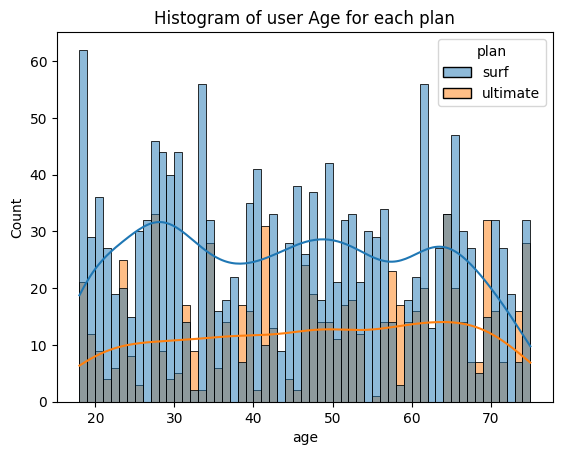

In [59]:

sns.histplot(data=consumption_summary, x="age", hue="plan", kde=True, binwidth=1).set(title='Histogram of user Age for each plan')


It looks like the histogram for the age of the users does not follow a consistent pattern, but we could note that overall user age can go up to 70+

#### Cities distribution

Let's check where are the users located

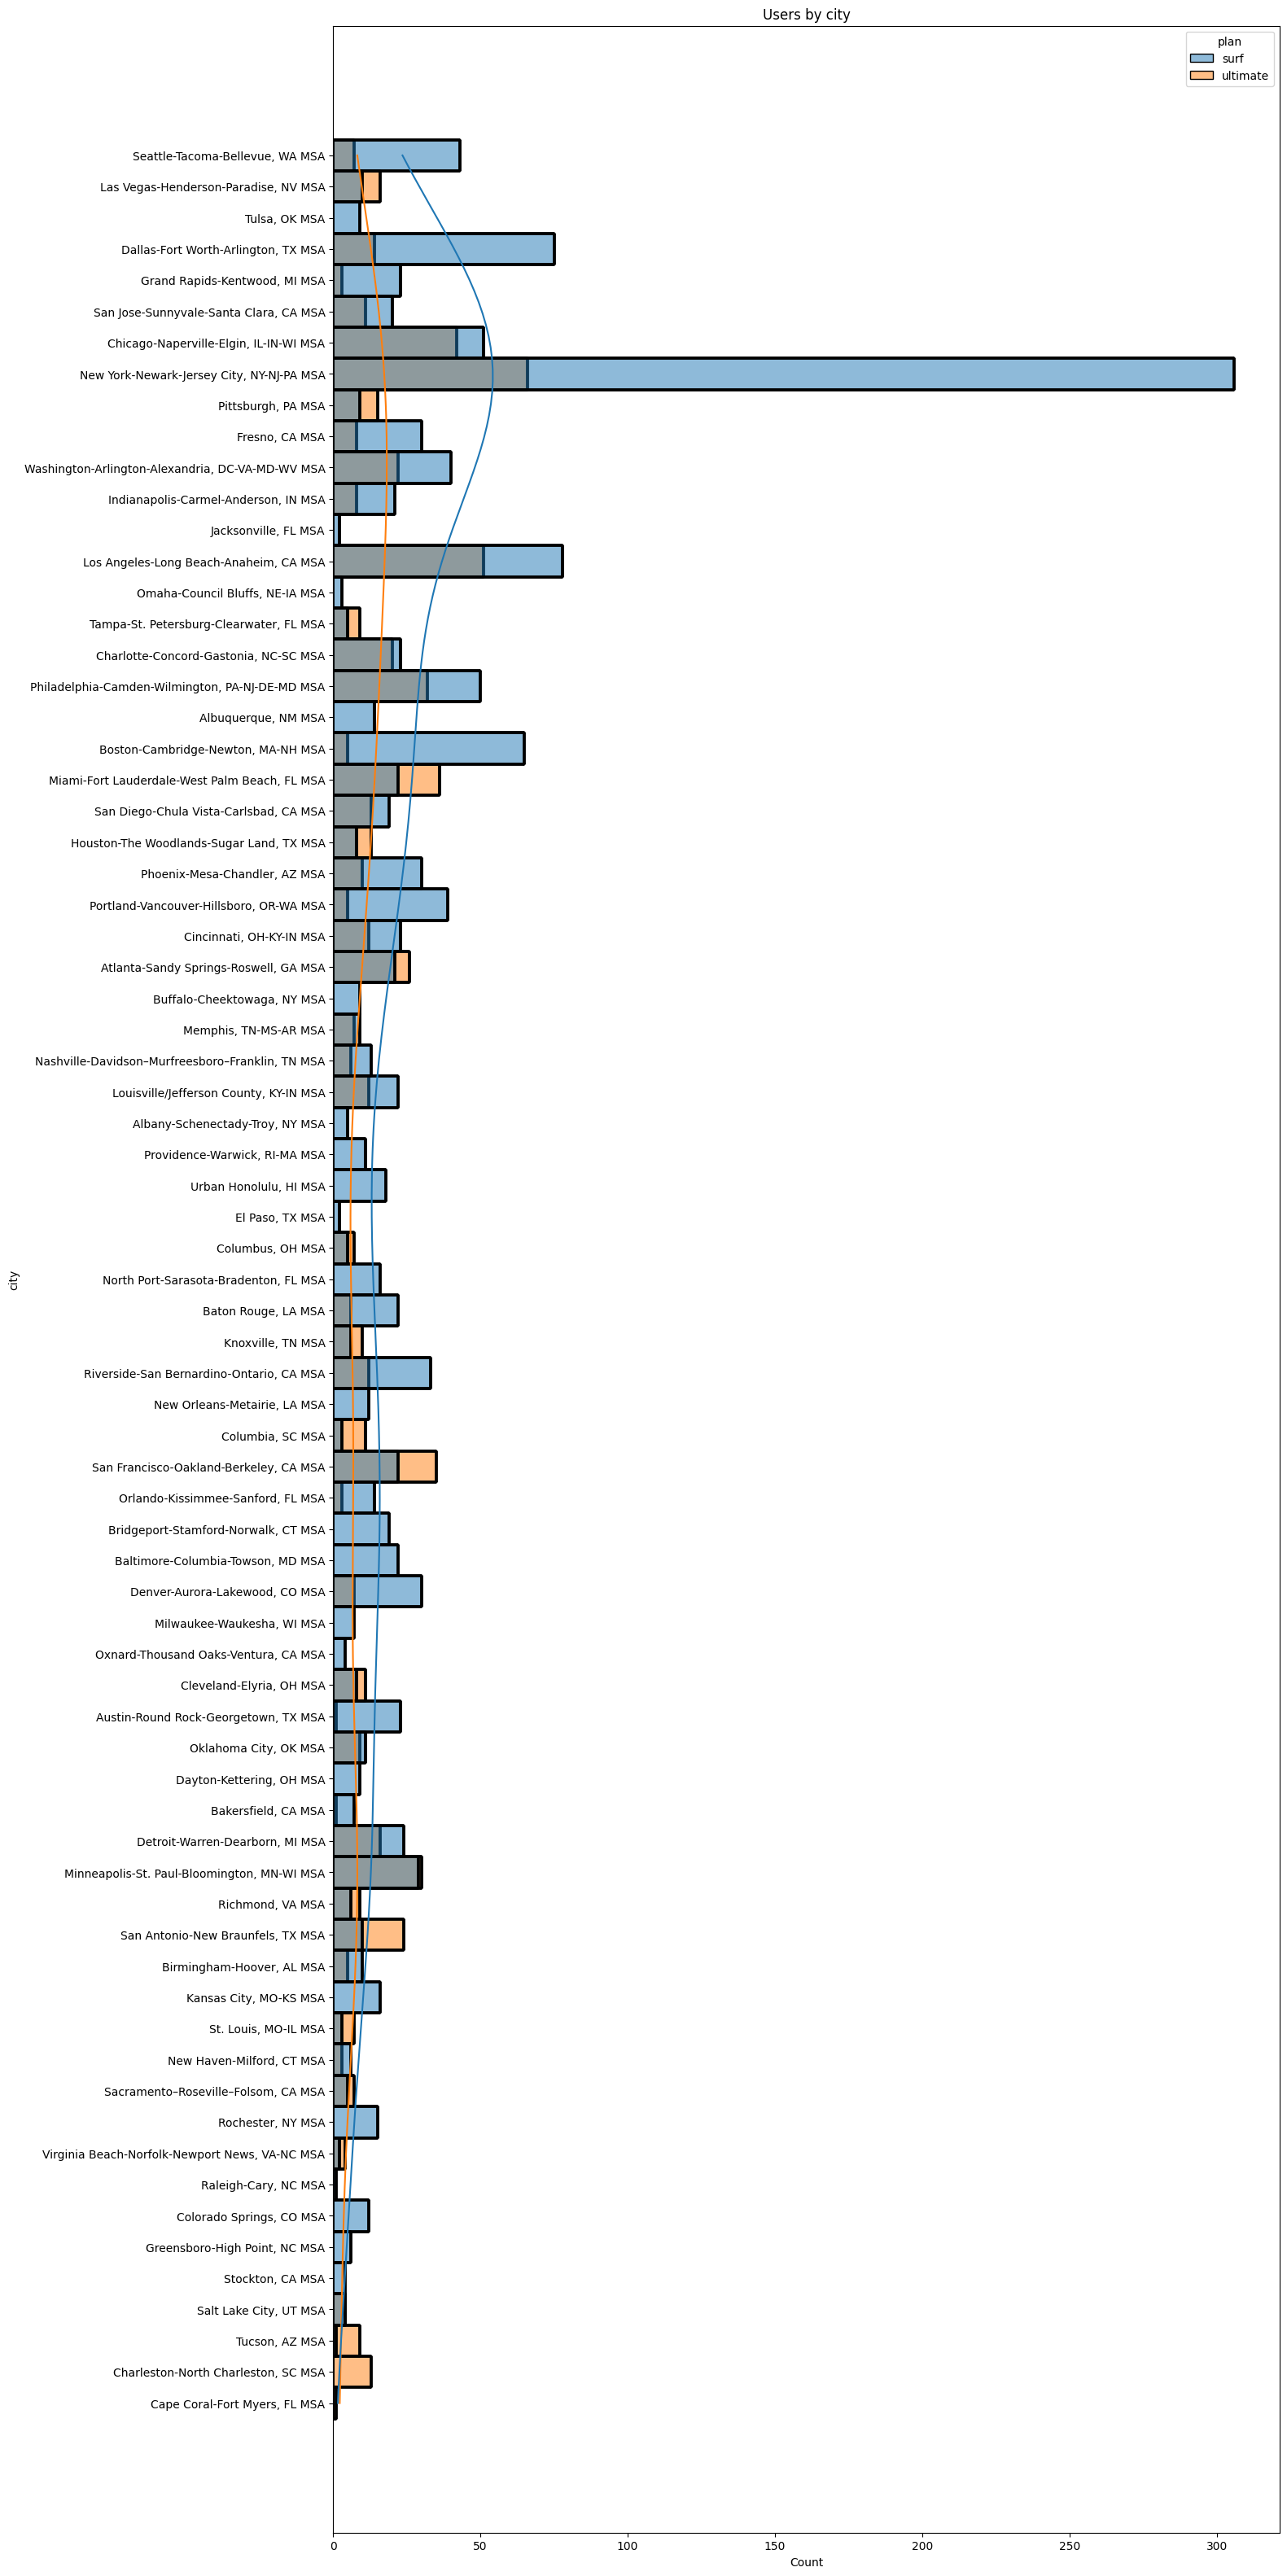

In [95]:
plt.figure(figsize=(15,40))

city_hist_plot = sns.histplot(data=consumption_summary, y='city', hue='plan', kde=True).set(title='Users by city')
r = plt.xticks(rotation=0)


We can conclude that most of our clients are located in the Neww York area

### Calls

<AxesSubplot:title={'center':'mean call duration for each plan monthly'}, xlabel='period', ylabel='duration (minutes)'>

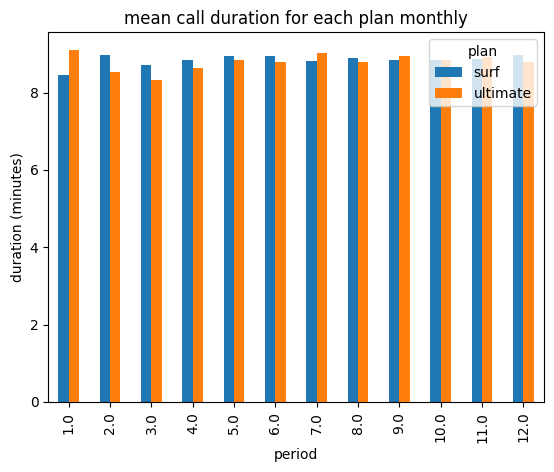

In [61]:
dataframes['calls_duration_monthly'] = consumption_summary.groupby(['period', 'plan']).sum().reset_index()
dataframes['calls_duration_monthly']['mean_duration'] =  dataframes['calls_duration_monthly']['call_total_minutes'] / dataframes['calls_duration_monthly']['calls_qty']
dataframes['calls_duration_monthly'].pivot_table(index='period',
                                                     columns='plan',
                                                     values='mean_duration').plot(kind='bar', title='mean call duration for each plan monthly', ylabel='duration (minutes)')


<AxesSubplot:title={'center':'Monthly mean call duration time histogram'}, xlabel='mean_call_duration', ylabel='Count'>

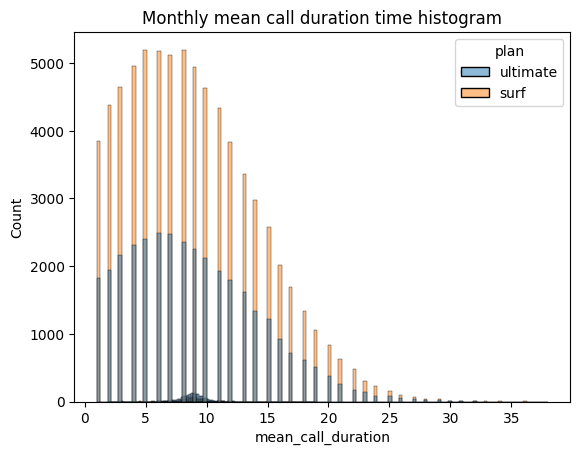

In [62]:
sns.histplot(consumption_summary, x='mean_call_duration', hue='plan').set(title='Monthly mean call duration time histogram')
sns.histplot(dataframes['calls'], x='duration', hue='plan')
# dataframes['calls']

__The call duration seems to be a very predictable value and there is not a clear difference between both plans__

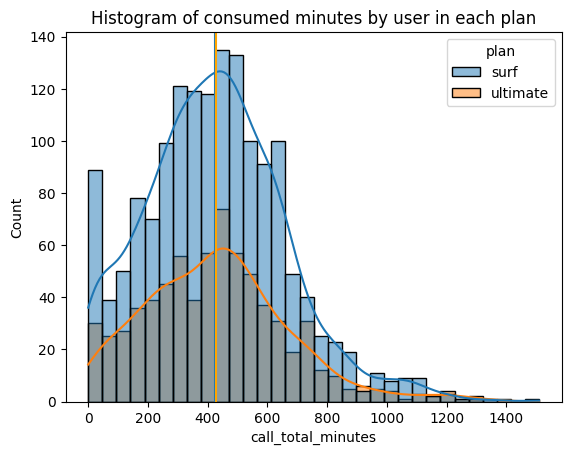

In [63]:
# Compara el número de minutos mensuales que necesitan los usuarios de cada plan. Traza un histograma.
sns.histplot(data=consumption_summary, x='call_total_minutes', hue='plan', kde=True).set(title='Histogram of consumed minutes by user in each plan')
plt.axvline(x=consumption_summary.query('plan=="surf"')['call_total_minutes'].mean())
plt.axvline(x=consumption_summary.query('plan=="ultimate"')['call_total_minutes'].mean(), color='orange')

plt.show()

In [64]:
agg_dict = {
    'call_total_minutes':['mean', 'median', 'std']
}
consumption_summary.groupby(['plan', 'period']).agg(agg_dict)


call_total_minutes                   
                              mean median         std
plan     period                                      
surf     1.0            203.000000  203.0  125.865007
         2.0            297.000000  254.0  228.531179
         3.0            330.000000  334.0  189.233622
         4.0            351.540000  339.5  225.536567
         5.0            399.584416  415.0  244.446763
         6.0            431.298969  423.0  213.524304
         7.0            449.983471  454.0  246.992105
         8.0            410.111111  392.0  233.119381
         9.0            408.773196  422.5  219.359029
         10.0           426.416309  429.0  229.877747
         11.0           418.518116  413.0  227.637774
         12.0           471.190789  448.5  254.605130
ultimate 1.0            193.500000  234.0  128.733575
         2.0            403.142857  428.0  277.289517
         3.0            304.250000  251.0  248.967732
         4.0            336.857143  301.0  186.785783
         5.0            406.241379  407.0  209.382537
         6.0            370.957447  399.0  206.163924
         7.0            427.067797  430.0  269.375898
         8.0            417.485714  404.5  230.864961
         9.0            440.523810  437.0  240.932349
         10.0           449.533333  461.0  235.851284
         11.0           446.467742  436.0  248.993925
         12.0           453.424658  434.0  251.589480

Text(0, 0.5, 'duration(minutes)')

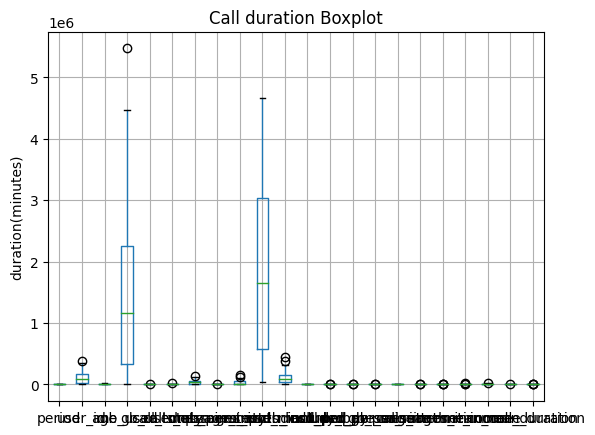

In [65]:
dataframes['calls_duration_monthly'].boxplot()
plt.title('Call duration Boxplot')
plt.ylabel('duration(minutes)')

The histogram shows that the distributions are very similar if we keep in mind the difference in the amount of users in each different plan.

Now we'd like to check some behaviors:
Let's start analyzing, how does the qty of total minutes vs age relation grouped by plan looks like?

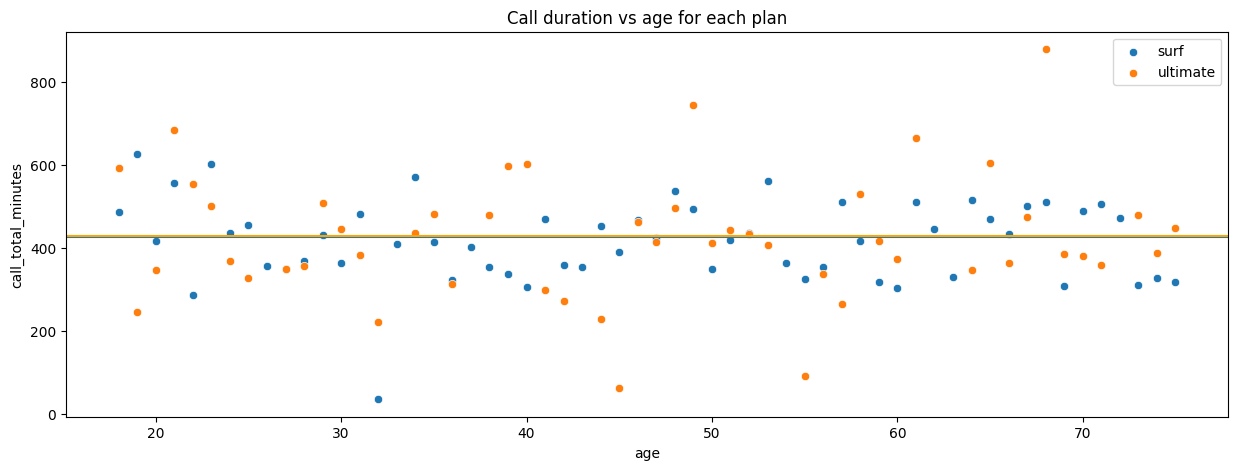

In [66]:
plt.figure(figsize=(15,5))
# sns.scatterplot(data=consumption_summary, x="age", y="call_total_minutes", size='income', hue='plan')
sns.scatterplot(data=consumption_summary.query('plan=="surf"').groupby('age').mean(), x="age", y="call_total_minutes", label='surf')
sns.scatterplot(data=consumption_summary.query('plan=="ultimate"').groupby('age').mean(), x="age", y="call_total_minutes", label='ultimate').set(title='Call duration vs age for each plan')

plt.axhline(y=consumption_summary.query('plan=="surf"')['call_total_minutes'].mean())
plt.axhline(y=consumption_summary.query('plan=="ultimate"')['call_total_minutes'].mean(), color='orange')



Now we'd like to check some behaviors:
Let's start analyzing, how does the qty of toal minutes vs income relation grouped by plan and age looks like?

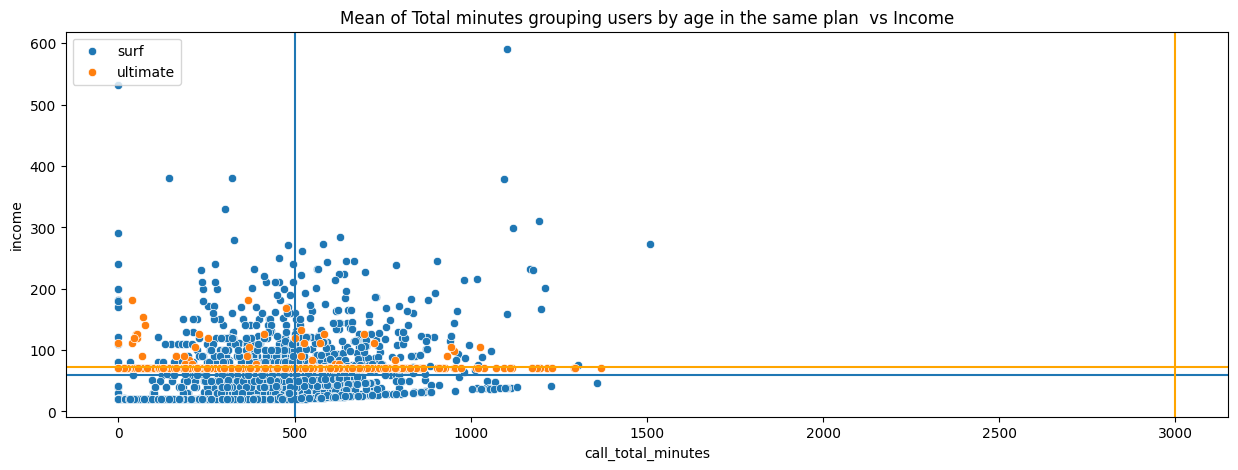

In [67]:
plt.figure(figsize=(15, 5))
sns.scatterplot(data=consumption_summary.query('plan=="surf"'), x="call_total_minutes", y="income", label='surf')
sns.scatterplot(data=consumption_summary.query('plan=="ultimate"'), x="call_total_minutes", y="income", label='ultimate').set(title='Mean of Total minutes grouping users by age in the same plan  vs Income')



plt.axhline(y=consumption_summary.query('plan=="ultimate"')['income'].mean(), color='orange')
plt.axhline(y=consumption_summary.query('plan=="surf"')['income'].mean())
plt.axvline(x=dataframes['plans'].iloc[0]['minutes_included'])
plt.axvline(x=dataframes['plans'].iloc[1]['minutes_included'], color='orange')


### Messages

<AxesSubplot:title={'center':'Mean of sent messages for each plan on a monthly basis'}, xlabel='period', ylabel='sent messages'>

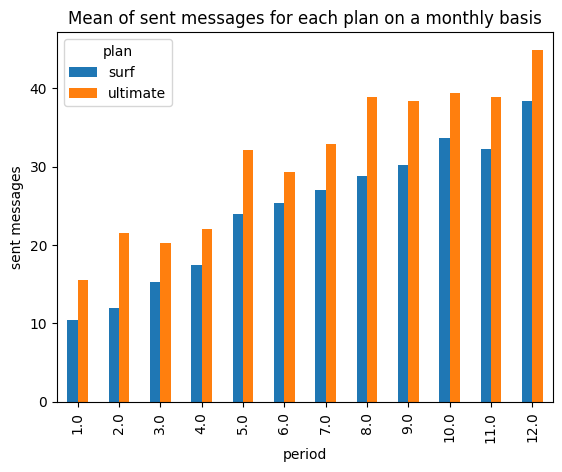

In [68]:
['user_id', 'plan', 'state', 'age', 'city', 'period', 'gb_used',
       'calls_qty', 'call_total_minutes', 'messages_qty', 'messages_included',
       'mb_per_month_included', 'minutes_included', 'usd_monthly_pay',
       'usd_per_gb', 'usd_per_message', 'usd_per_minute', 'gb_per_month',
       'calls_income', 'messages_income', 'internet_income', 'income']

dataframes['messages_qty_monthly'] = consumption_summary.groupby(['period', 'plan'])['messages_qty'].mean().reset_index()

dataframes['messages_qty_monthly'] = dataframes['messages_qty_monthly'].pivot_table(
                                                                                    index = 'period',
                                                                                    columns='plan',
                                                                                    values= 'messages_qty'
                                                                                   )
# print('Monthly messages by plan', dataframes['messages_qty_monthly'])

consumption_summary.groupby(['period','plan']).mean().pivot_table(
                                                    index = 'period',
                                                    columns='plan',
                                                    values= 'messages_qty'
                                                   ).plot(kind='bar', 
                                                          y=['surf', 'ultimate'], 
                                                          title='Mean of sent messages for each plan on a monthly basis',
                                                          ylabel='sent messages')


__The bar plot suggest an incremental tendence__


In [69]:
# We can try different values for period inthe query[1, 12]
dataframes['messages'].query('period==12 and plan=="surf"')

,id,user_id,message_date,period,plan
13,1001_5,1001,2018-12-05,12,surf
18,1001_17,1001,2018-12-11,12,surf
21,1001_21,1001,2018-12-30,12,surf
24,1001_30,1001,2018-12-14,12,surf
31,1001_46,1001,2018-12-17,12,surf
...,...,...,...,...,...
74372,1496_27,1496,2018-12-09,12,surf
74376,1496_31,1496,2018-12-13,12,surf
74387,1496_42,1496,2018-12-21,12,surf
74399,1496_54,1496,2018-12-12,12,surf


__users with surf plan usually send more messages than user in the ultimate plan. Monthy by month users in both plans increases and so the total amount of messages sent__

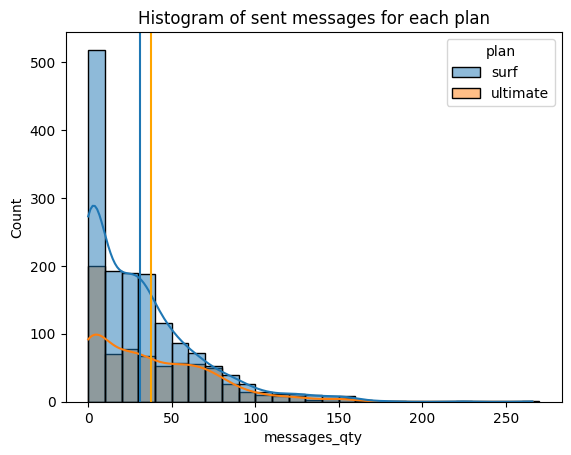

In [70]:
sns.histplot(data=consumption_summary,
             x="messages_qty", 
             color="skyblue",
             kde=True, 
             binwidth=10,
            hue='plan').set(title='Histogram of sent messages for each plan')
plt.axvline(x=consumption_summary.query('plan=="surf"')['messages_qty'].mean())
plt.axvline(x=consumption_summary.query('plan=="ultimate"')['messages_qty'].mean(), color='orange')


[Text(0.5, 1.0, 'Boxplot of sent messages ')]

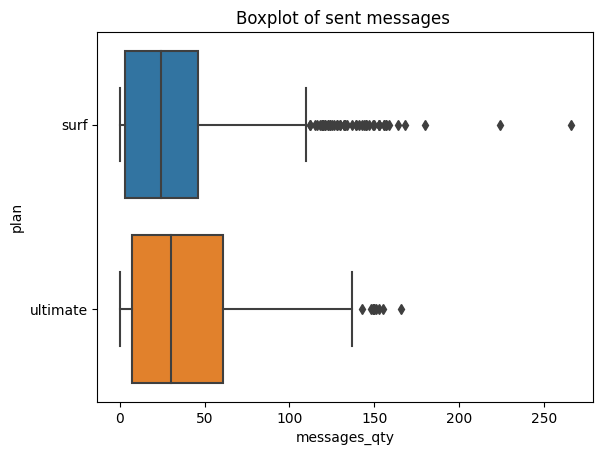

In [71]:
sns.boxplot(data=consumption_summary, x='messages_qty', y='plan').set(title='Boxplot of sent messages ')

Now we'd like to check some behaviors:
Let's start analyzing, how does the qty of messages vs age relation grouped by plan looks like?

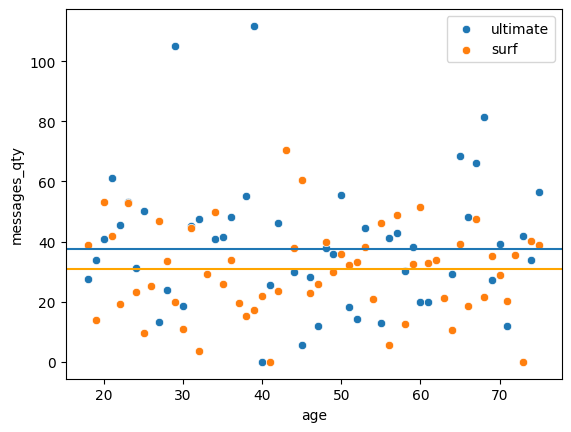

In [72]:
sns.scatterplot(data=consumption_summary.query('plan=="ultimate"').groupby('age').mean(), x="age", y="messages_qty", label='ultimate')
sns.scatterplot(data=consumption_summary.query('plan=="surf"').groupby('age').mean(), x="age", y="messages_qty", label='surf')
plt.axhline(y=consumption_summary.query('plan=="ultimate"')['messages_qty'].mean())
plt.axhline(y=consumption_summary.query('plan=="surf"')['messages_qty'].mean(), color='orange')


Now we'd like to check some behaviors:
Let's start analyzing, how does the qty of messages vs income relation grouped by plan and age looks like?

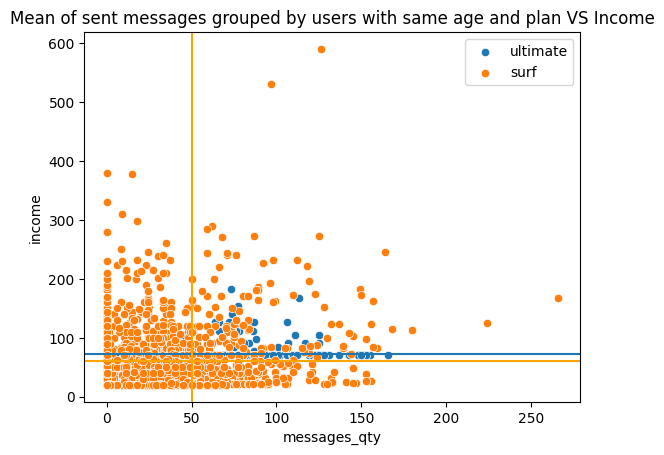

In [73]:
sns.scatterplot(data=consumption_summary.query('plan=="ultimate"'), x="messages_qty", y="income", label='ultimate')
sns.scatterplot(data=consumption_summary.query('plan=="surf"'), x="messages_qty", y="income", label='surf').set(title='Mean of sent messages grouped by users with same age and plan VS Income')
plt.axhline(y=consumption_summary.query('plan=="ultimate"').mean()['income'])
plt.axhline(y=consumption_summary.query('plan=="surf"').mean()['income'], color='orange')
plt.axvline(x=dataframes['plans'].iloc[0]['messages_included'], color='orange')
# plt.axvline(x=dataframes['plans'].iloc[1]['messages_included'])


### Internet

Internet traffic by plan on a monthly baisis
 plan         surf   ultimate
period                      
1.0      5.000000   7.250000
2.0     12.222222  17.285714
3.0     13.565217  18.416667
4.0     12.220000  16.333333
5.0     14.116883  16.862069
6.0     15.484536  15.425532
7.0     16.876033  16.491525
8.0     16.882716  17.842857
9.0     16.489691  17.190476
10.0    17.347639  17.523810
11.0    16.297101  17.153226
12.0    18.108553  18.191781


<AxesSubplot:title={'center':'Mean internet consumption by users grouped by plan on a monthly basis'}, xlabel='period', ylabel='consumption (GB)'>

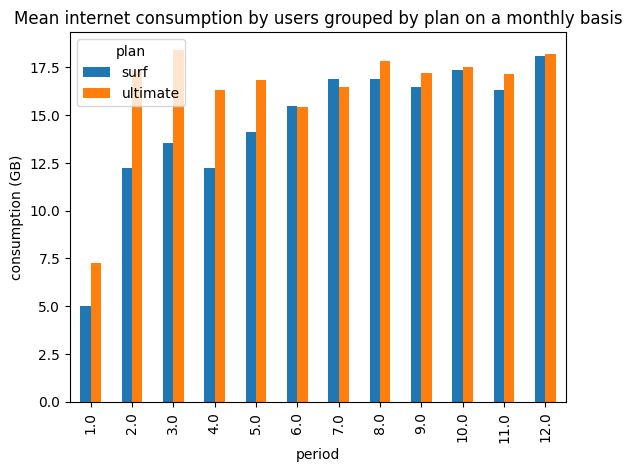

In [74]:
dataframes['internet_traffic_monthly'] = consumption_summary.groupby(['period', 'plan'])['gb_used'].mean().reset_index()

dataframes['internet_traffic_monthly'] = dataframes['internet_traffic_monthly'].pivot_table(index='period',
                                                                                           columns='plan',
                                                                                           values='gb_used')

print('Internet traffic by plan on a monthly baisis\n', dataframes['internet_traffic_monthly'])

consumption_summary.groupby(['period', 'plan']).mean().reset_index().pivot_table(index='period',
                                                                                columns='plan',
                                                                                values='gb_used').plot(kind='bar', y=['surf', 'ultimate'], title='Mean internet consumption by users grouped by plan on a monthly basis', ylabel='consumption (GB)')


In [75]:
consumption_summary.groupby(['period', 'plan'])[['gb_used']].describe()

gb_used                                                     
                  count       mean        std  min    25%   50%    75%   max
period plan                                                                 
1.0    surf         2.0   5.000000   4.242641  2.0   3.50   5.0   6.50   8.0
       ultimate     4.0   7.250000   3.862210  2.0   5.75   8.0   9.50  11.0
2.0    surf         9.0  12.222222   6.437736  1.0   7.00  12.0  16.00  20.0
       ultimate     7.0  17.285714   6.156684  5.0  16.50  20.0  20.50  22.0
3.0    surf        23.0  13.565217   7.999012  2.0   6.50  14.0  19.00  30.0
       ultimate    12.0  18.416667  11.774073  2.0   8.25  21.0  28.75  36.0
4.0    surf        50.0  12.220000   7.497728  0.0   6.25  12.0  17.75  28.0
       ultimate    21.0  16.333333   9.264628  3.0   9.00  16.0  21.00  37.0
5.0    surf        77.0  14.116883   7.627813  0.0   8.00  14.0  20.00  36.0
       ultimate    29.0  16.862069   7.361697  3.0  14.00  17.0  21.00  33.0
6.0    surf        97.0  15.484536   6.910308  0.0  12.00  16.0  19.00  37.0
       ultimate    47.0  15.425532   8.298100  2.0  10.50  15.0  20.00  38.0
7.0    surf       121.0  16.876033   7.840674  0.0  13.00  17.0  21.00  39.0
       ultimate    59.0  16.491525   8.015874  1.0  12.00  15.0  21.00  38.0
8.0    surf       162.0  16.882716   8.451091  0.0  12.00  17.0  21.00  51.0
       ultimate    70.0  17.842857   7.673851  1.0  14.00  18.0  21.00  40.0
9.0    surf       194.0  16.489691   7.139788  0.0  12.00  17.0  21.00  37.0
       ultimate    84.0  17.190476   6.852097  4.0  13.00  17.0  20.00  37.0
10.0   surf       233.0  17.347639   7.847370  0.0  12.00  18.0  21.00  46.0
       ultimate   105.0  17.523810   7.535933  0.0  13.00  17.0  21.00  46.0
11.0   surf       276.0  16.297101   7.440342  0.0  12.00  17.0  20.00  42.0
       ultimate   124.0  17.153226   7.458333  1.0  13.00  17.0  21.00  42.0
12.0   surf       304.0  18.108553   8.330511  0.0  14.00  18.0  22.00  70.0
       ultimate   146.0  18.191781   7.775572  1.0  13.25  17.0  22.00  46.0

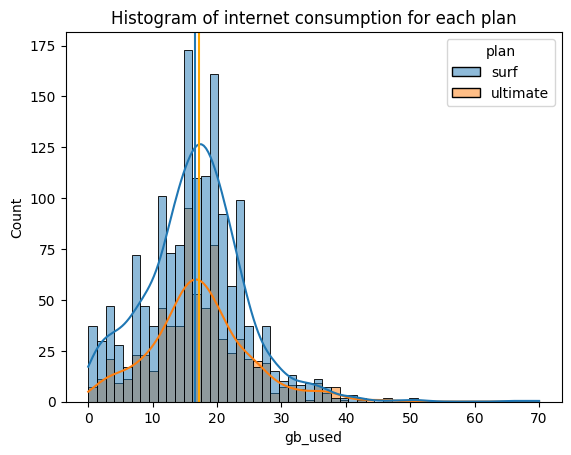

In [76]:
sns.histplot(data=consumption_summary, x='gb_used', hue='plan', kde=True).set(title='Histogram of internet consumption for each plan')
plt.axvline(x=consumption_summary.query('plan=="surf"')['gb_used'].mean() )
plt.axvline(x=consumption_summary.query('plan=="ultimate"')['gb_used'].mean(), color='orange' )

plan         surf   ultimate
period                      
1.0      5.000000   7.250000
2.0     12.222222  17.285714
3.0     13.565217  18.416667
4.0     12.220000  16.333333
5.0     14.116883  16.862069
6.0     15.484536  15.425532
7.0     16.876033  16.491525
8.0     16.882716  17.842857
9.0     16.489691  17.190476
10.0    17.347639  17.523810
11.0    16.297101  17.153226
12.0    18.108553  18.191781


Text(0.5, 1.0, 'Internet consumption (GB) boxplot')

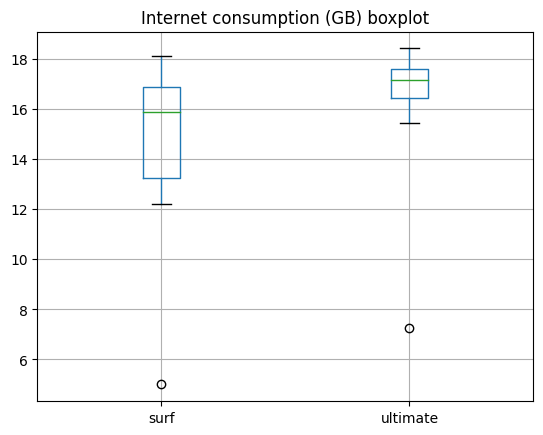

In [77]:
print(dataframes['internet_traffic_monthly'])
dataframes['internet_traffic_monthly'].boxplot()
plt.title('Internet consumption (GB) boxplot')

Now we'd like to check some behaviors:
Let's start analyzing, how does the qty of gb used vs age relation grouped by plan looks like?

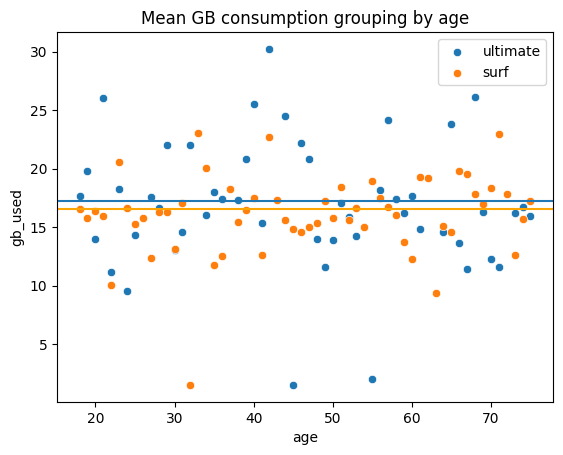

In [78]:
sns.scatterplot(data=consumption_summary.query('plan=="ultimate"').groupby('age').mean(), x="age", y="gb_used", label='ultimate')
sns.scatterplot(data=consumption_summary.query('plan=="surf"').groupby('age').mean(), x="age", y="gb_used", label='surf').set(title='Mean GB consumption grouping by age')

plt.axhline(y=consumption_summary.query('plan=="surf"')['gb_used'].mean(),color='orange')
plt.axhline(y=consumption_summary.query('plan=="ultimate"')['gb_used'].mean())

Now we'd like to check some behaviors:
Let's start analyzing, how does the qty of messages vs income relation grouped by plan and age looks like?

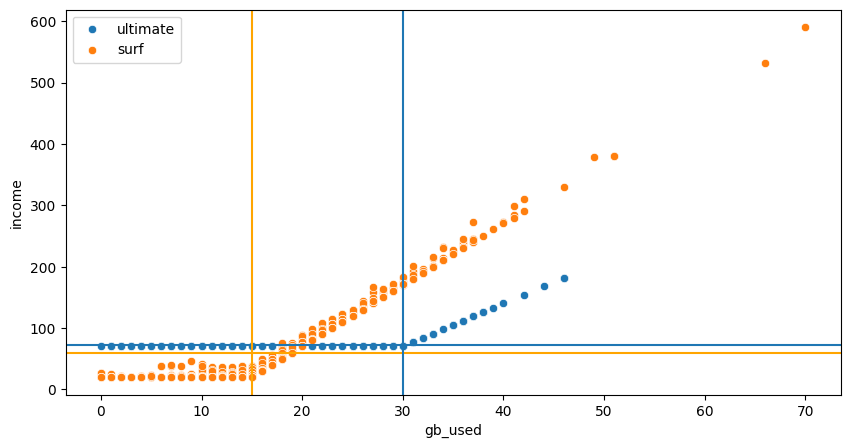

In [79]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=consumption_summary.query('plan=="ultimate"'), x="gb_used", y="income", label='ultimate')
sns.scatterplot(data=consumption_summary.query('plan=="surf"'), x="gb_used", y="income", label='surf')

plt.axhline(y=consumption_summary.query('plan=="surf"')['income'].mean(), color='orange')
plt.axhline(y=consumption_summary.query('plan=="ultimate"')['income'].mean())

plt.axvline(x=dataframes['plans'].iloc[0]['gb_per_month'], color='orange')
plt.axvline(x=dataframes['plans'].iloc[1]['gb_per_month'])

Users in surf plan need more mb to consume.

## Ingreso

Let's check the total monthly income for each plan

<AxesSubplot:xlabel='period'>

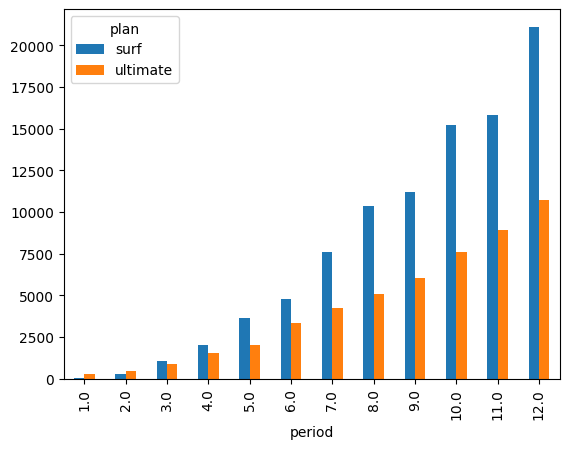

In [80]:
income_plan_monthly = consumption_summary.groupby(['period', 'plan'])['income'].sum().reset_index()
income_plan_monthly = income_plan_monthly.pivot_table(index='period', columns='plan', values='income')
income_plan_monthly
income_plan_monthly.plot(kind='bar', y=['surf', 'ultimate'])

It looks like the income has increased month by month, this cloud be explained for the new users that adquire new plans

Now let's check the histogram for income for each plan

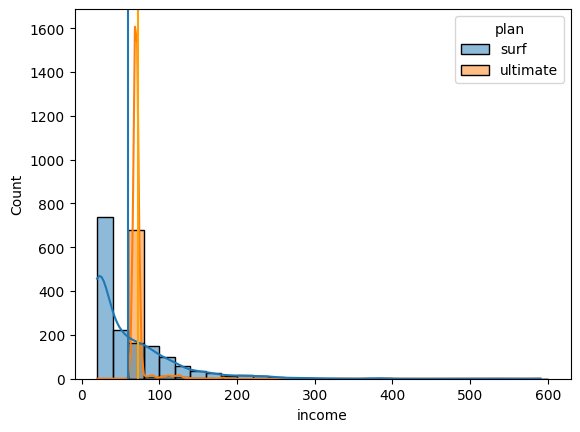

In [81]:
sns.histplot(data=consumption_summary, x='income', hue='plan', binwidth=20, kde=True)
plt.axvline(x=consumption_summary.query('plan=="surf"')['income'].mean())
plt.axvline(x=consumption_summary.query('plan=="ultimate"')['income'].mean(), color='orange')

<AxesSubplot:xlabel='income', ylabel='Count'>

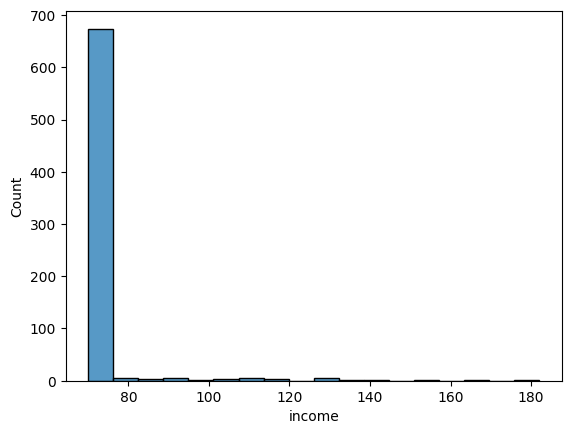

In [82]:
sns.histplot(data=consumption_summary.query('plan=="ultimate"'), x='income', bins=18)

__Bill paid by Ultimate plan users is sligthly expensive, but we know that there are more surf plan users in total__

Now let's examine the total income with a boxplot

<AxesSubplot:>

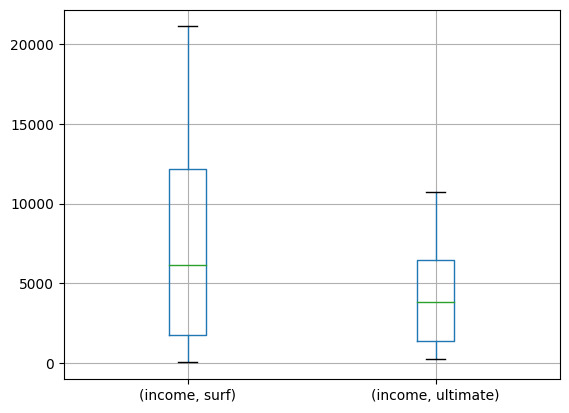

In [83]:
consumption_summary.groupby(['period', 'plan'])['income'].sum().reset_index().pivot_table(
                                                                                            index='period',
                                                                                            columns='plan'
                                                                                        ).boxplot()

__When we analyze the total income monthly for each plan we can notice that surf plan users contribute more to this value__

There are some ideas to discuss based on the gathered information:
- Ultimate plan users usually have less variation than surf plan users.
- Surf plan users could be more likely to pay a diferent amount at the end of the month 
- Surf plan users are more profitable than ultimate plan users

Analysis of revenue:
Let's first start analyzing the income coming for calls (calls)

[Text(0.5, 1.0, 'Histogram if income for calls')]

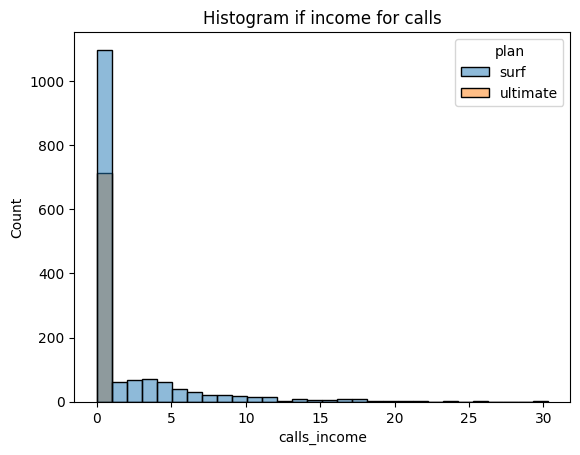

In [84]:
sns.histplot(data=consumption_summary, x='calls_income', hue='plan', bins=30).set(title='Histogram if income for calls')

[Text(0.5, 1.0, 'Extra income for internet consumption histogram')]

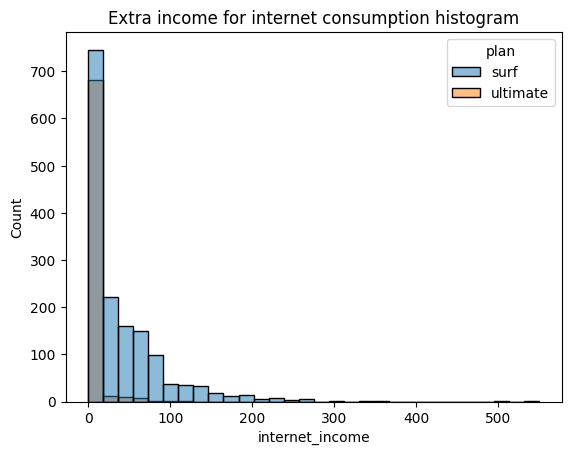

In [85]:
sns.histplot(data=consumption_summary, x='internet_income', hue='plan', bins=30).set(title='Extra income for internet consumption histogram')

[Text(0.5, 1.0, 'Extra income for messages histogram')]

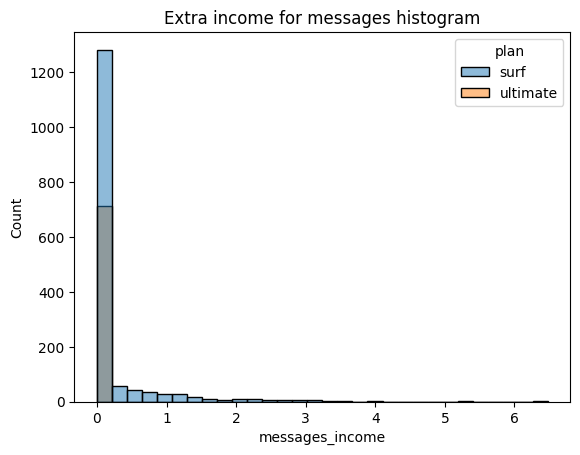

In [86]:
sns.histplot(data=consumption_summary, x='messages_income', hue='plan', bins=30).set(title='Extra income for messages histogram')

[Text(0.5, 1.0, 'extra income behavior lineplot'),
 Text(0, 0.5, 'extra income ($)')]

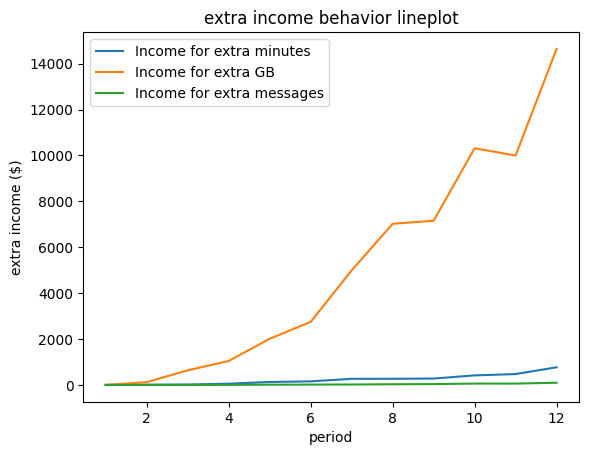

In [87]:
# print(consumption_summary)
sns.lineplot(data=consumption_summary.groupby('period').sum()
            , x='period', y='calls_income', label='Income for extra minutes')
sns.lineplot(data=consumption_summary.groupby('period').sum()
            , x='period', y='internet_income', label='Income for extra GB')
sns.lineplot(data=consumption_summary.groupby('period').sum()
            , x='period', y='messages_income', label='Income for extra messages').set(title='extra income behavior lineplot', ylabel='extra income ($)')

[Text(0.5, 1.0, 'Surf plan users extra income behavior lineplot'),
 Text(0, 0.5, 'extra income ($)')]

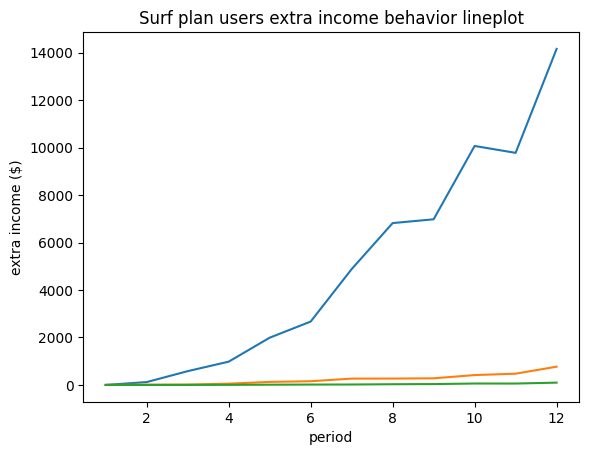

In [88]:
sns.lineplot(data=consumption_summary.query('plan=="surf"').groupby('period').sum(), x='period', y='internet_income')
sns.lineplot(data=consumption_summary.query('plan=="surf"').groupby('period').sum(), x='period', y='calls_income')
sns.lineplot(data=consumption_summary.query('plan=="surf"').groupby('period').sum(), x='period', y='messages_income').set(title='Surf plan users extra income behavior lineplot', ylabel='extra income ($)')

The pot bellow shows the Income obtained for each service (internet, calls and messages) on a monthly baisis for Surf users.

The internet was the service that contributed the most additional income

[Text(0.5, 1.0, 'Ultimate plan users extra income behavior lineplot'),
 Text(0, 0.5, 'extra income ($)')]

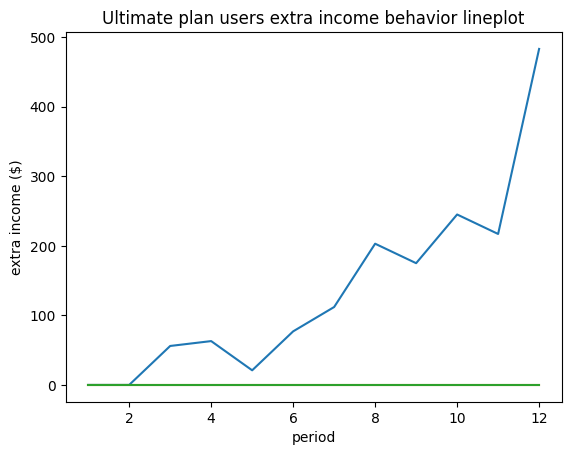

In [89]:
sns.lineplot(data=consumption_summary.query('plan=="ultimate"').groupby('period').sum(), x='period', y='internet_income')
sns.lineplot(data=consumption_summary.query('plan=="ultimate"').groupby('period').sum(), x='period', y='calls_income')
sns.lineplot(data=consumption_summary.query('plan=="ultimate"').groupby('period').sum(), x='period', y='messages_income').set(title='Ultimate plan users extra income behavior lineplot', ylabel='extra income ($)')

- Users in surf plan are more profitable than users in ultimate plan. 
- Users in ultimate plan usually not need to pay more because its higher consumtion limits.

The pot bellow shows the Income obtained for each service (internet, calls and messages) on a monthly baisis for Ultimate users.

The internet was the service that contributed the most additional income

__Conclusions:__

- The most of the extra income comes from extra internet consumption. 
- Surf plan users add more extra income for extra internet consumption than ultimate users.
- Ultimate plan users have enough minutes and messages, therefore the extra income coming from those services is zero

## TTest hypothesis testing

### Hypothesis 1
Null hypothesis: The income from the two different plans are the same


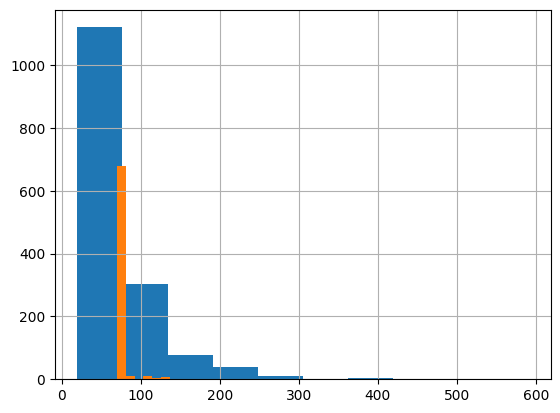

4.291767196957435e-09


In [90]:
consumption_summary.query('plan=="surf"')['income'].hist(),
consumption_summary.query('plan=="ultimate"')['income'].hist(),
plt.show()
  
result = st.ttest_ind(
    consumption_summary.query('plan=="surf"')['income'],
    consumption_summary.query('plan=="ultimate"')['income'],
    equal_var = True
)

print(result.pvalue)

Based in the p-value we conclude that the income from the two plans are different.

### Hypothesis 2:

User behaviour can be vary from area to area, let's review the NY-NJ:
Null hypothesis: The income from 
La hipotesis nula es: los ingresos por ambos conjuntos es el mismo.

7.360557253776062e-16


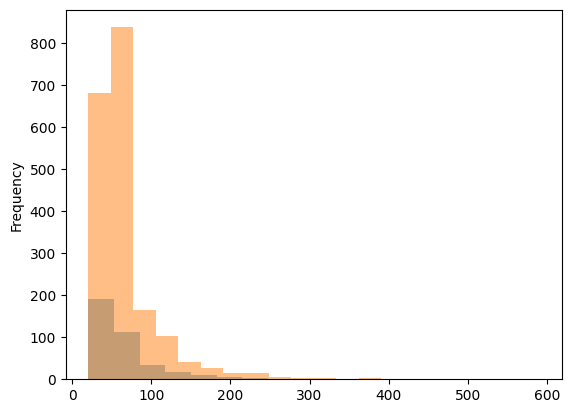

In [91]:
ny_nj_users = consumption_summary.query('state=="NY-NJ-PA"')

rest = consumption_summary.query('state!="NY-NJ-PA"')


result = st.ttest_ind(
    ny_nj_users.query('plan=="surf"')['income'],
    rest.query('plan=="ultimate"')['income'],
    equal_var = True
)

print(result.pvalue)

ny_nj_users['income'].plot(kind='hist',alpha=0.5,label=True, bins=8)
rest['income'].plot(kind='hist', alpha=0.5,label=True, bins=20)
plt.show()

El p valor indica que los ingresos provenientes por ambos conjuntos son diferentes

## Conclusion

Based on the previous analysis the following are the final results: